Cytochromes P450 - Reactions

Below is the code that can be used to identify and split reactions.

Firstly I need to install all necessary packages:

In [19]:
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRascalMCES
import pandas as pd

Next, I need to import the database from the excel sheet as a pandas dataframe and preprocess it - i am only taking the rows where there are some records for the reactions.

In [20]:
df = pd.read_csv("Cytochrome P450 database - CYPsdb.csv")
df2 = df.copy()

I am going to use two helper functions, they are very similar to the ones i use in the file final_MCS.ipynb for determining the SMARTS - get_chaning_index() and set_pattern()

In [21]:
#This is a function which gets us the index of the changing atom
def get_changing_index(molecule, pattern):
    """
    Gets the index of the changing atom(s).
    First finds the atoms that correspond to pattern and saves as hit_atoms.
    Then, saves all possible atoms, substraction of these two sets gives the changing atoms.
    """
    hit_atoms = list(molecule.GetSubstructMatch(pattern))
    all_atoms_prod = list(molecule.GetSubstructMatch(molecule))
    resulting_index = set(all_atoms_prod)-set(hit_atoms)
    return resulting_index

In [22]:
def pattern_using_MCS(structure_1, structure_2):
    """
    Takes two structures, uses structure_1 as a pattern for structure_2. 
    If this isnt possible, finds maximum common substructure and uses it as a pattern instead.
    Returns molecule and pattern. This function is used if Rascal MCES isn't possible. 
    """
    pattern = Chem.MolFromSmiles(structure_1)
    molecule = Chem.MolFromSmiles(structure_2)
    hit_atoms = list(molecule.GetSubstructMatch(pattern))
    #First, we need to check if there are any hit atoms = if the molecule has a pattern
    if len(hit_atoms) == 0:
        MCS_pattern = rdFMCS.FindMCS([molecule,pattern])
        pattern = Chem.MolFromSmarts(MCS_pattern.smartsString)
        hit_atoms = list(molecule.GetSubstructMatch(pattern))
    if len(hit_atoms) == 0:
        print("Hit atoms still zero after using MCS!")
        return None
    return get_changing_index(molecule, pattern)

In [23]:
def set_pattern(structure1,structure2):
    """
    Sets pattern and molecule, then uses get_changing_index().
    Attempts to use Rascal MCES to get multifragment maximum common substructure and use this as a pattern. 
    Checks for errors, if there is none, gets the changing index.
    If there is an error or Rascal MCES isn't possible, uses a different approach via pattern_using_MCS().
    """
    s1 = Chem.MolFromSmiles(structure1)
    s2 = Chem.MolFromSmiles(structure2)
    result_p = rdRascalMCES.FindMCES(s1,s2)
    if result_p != []:
        try:
            result_p[0].smartsString
            pattern = Chem.MolFromSmarts(result_p[0].smartsString)
            return get_changing_index(s2, pattern)
        except (IndexError, AttributeError, ValueError, RuntimeError):
            return pattern_using_MCS(structure1, structure2)
    else:
        return pattern_using_MCS(structure1, structure2)

In [24]:
def chemical_reaction(subs,prod):
    """ 
    Takes a substrate and a product as an input, uses set_pattern() to find the index(es) of a changing atom(s) and the valence(s).
    Returns changing atom(s) and valence(s) for substrate and product
    """
    index_1 = set_pattern(subs,prod)
    index_2 = set_pattern(prod,subs)
    substrate_list = []
    product_list = []
    # Here it loops through all changing indexes, checks if each index in substrate is valid, if yes it records the valence and symbol
    if index_2:
        for i in list(index_2):
            index_subs = i
            changing_atom_subs = Chem.MolFromSmiles(subs).GetAtomWithIdx(index_subs).GetSymbol()
            changing_valence_subs = Chem.MolFromSmiles(subs).GetAtomWithIdx(index_subs).GetExplicitValence()
            substrate_list.append(changing_atom_subs)
            substrate_list.append(changing_valence_subs)
    # If it isnt valid (is an empty set), the atom does not exist (either was added or removed by the reaction)
    # Here it does the same thing for the index(es) in product
    if index_1:
        for j in list(index_1):
            index_prod = j
            changing_atom_prod = Chem.MolFromSmiles(prod).GetAtomWithIdx(index_prod).GetSymbol()
            changing_valence_prod = Chem.MolFromSmiles(prod).GetAtomWithIdx(index_prod).GetExplicitValence()
            product_list.append(changing_atom_prod)
            product_list.append(changing_valence_prod)
    return substrate_list, product_list

In [25]:
from collections import Counter
def checking_keys_in_dictionary(key, dick):
    """
    Inputs are a key and a dictionary. Checks if the key appears in some form in the input dictionary.
    If yes, returns True and the key. If not, returns False and None.
    Example of use: reaction 1 is defined: ('C', 1, 'O', 1, 'C', 2), reaction 2: ('O', 1, 'C', 1, 'C', 2); they could be the same just differently ordered.
    If this function wasn't used, they would be recorded as two different reactions even though they are the same.
    """
    for new_keys in dick.keys(): 
        if Counter(key) == Counter(new_keys):
            return True, new_keys
    return False, None

In [26]:
def bond_types(smiles_structure):
    """
    Gets the number of each bond type - single, double and aromatic.
    Loops through all bonds in the input structure.
    Ouputs the number of occurances of each type.
    """
    s_single, s_aromatic, s_double = 0, 0, 0
    for bond in smiles_structure.GetBonds():
        n = bond.GetIdx()
        if str(smiles_structure.GetBondWithIdx(n).GetBondType()) == "SINGLE":
            s_single += 1
        elif str(smiles_structure.GetBondWithIdx(n).GetBondType()) == 'AROMATIC':
            s_aromatic += 1
        elif str(smiles_structure.GetBondWithIdx(n).GetBondType()) == 'DOUBLE':
            s_double += 1
    return s_single, s_aromatic, s_double

In [27]:
def idenitfy_reactions(dataframe):
    """
    This is the function that can be used to loop through all the reactions and identify them.
    The input here is only the dataframe, chemical_reaction() function is used to identify the reaction.
    Some reactions aren't identified straightaway so "if/elif" statements are used to manually alter this.
    The indexes of those altered are saved to a list so that they can be checked afterwards.
    The first output is a dictionary: keys are reactions, values the indexes.
    Second output is a list of indexes of manually altered reactions.
    """
    reaction_groups_index = {}
    manually_altered_reactions = []
    for i, row in dataframe.iterrows():
        if pd.notna(row['Substrate SMILES']) and pd.notna(row['Product SMILES']):
            print(i)
            sub = max(row['Substrate SMILES'].split(';'),key=len)
            prod = max(row['Product SMILES'].split(';'),key=len)
            s_change, p_change = chemical_reaction(sub,prod)
            reaction = tuple(s_change + p_change)
            if reaction == ('H',1,'O',1): 
                # Manually identified group,hydroxylation happens (rdkit didnt ignore hydrogen atom)
                reaction = ('O',1)
                manually_altered_reactions.append(i)
            elif reaction == ():
                # If no other reaction was identified, it might be one of the cases below:
                s_sub = Chem.MolFromSmiles(sub)
                s_prod = Chem.MolFromSmiles(prod)
                s_single, s_aromatic, s_double = bond_types(s_sub)
                p_single, p_aromatic, p_double = bond_types(s_prod)
                if (sub == '*[H]') and (prod == '*[O]'):
                    # Sometimes there is a very general notation in the database, this one stands for hydroxylation
                    reaction = ('O',1)
                    manually_altered_reactions.append(i)
                elif s_sub.GetRingInfo().NumRings() != s_prod.GetRingInfo().NumRings():
                    # If the number of rings isnt consistent, a ring must have been created
                    reaction = ('ring')
                    manually_altered_reactions.append(i)
                elif (s_single != p_single) and (s_aromatic != p_aromatic):
                    # If the number of aromatic and single bond has changed, one of the rings changed aromaticity
                    reaction = ('ring')
                    manually_altered_reactions.append(i)
                elif (s_single != p_single) and (s_double != p_double):
                    # If the number of single AND double bonds changed, double bond was created
                    reaction = ('double bond')
                    manually_altered_reactions.append(i)
                elif ('[Fe-]' in sub) and ('[Fe--]' in prod):
                    # Checks for these specific iron atoms in the structures
                    reaction = ('central iron atom reduction')
                    manually_altered_reactions.append(i)
            elif reaction == ('C',2,'C',2,'C',3,'C',3):
                # Manually identified group where change in aromaticity happens
                reaction = ('ring')
                manually_altered_reactions.append(i)
            elif reaction == ('C', 3, 'C', 3, 'O', 1) or reaction == ('C', 3, 'C', 1, 'O', 1):
               # Manually identified groups where hydroxylation happens (there is also one E/Z change)
                reaction = ('O',1)
                manually_altered_reactions.append(i)
            elif reaction == ('C', 3, 'C', 2, 'C', 4, 'C', 1, 'C', 4, 'C', 1, 'C', 4, 'O', 1, 'C', 3) or reaction == ('C', 3, 'C', 3, 'C', 4, 'O', 1, 'C', 3):
                # Manually identified groups where hydroxylation is accompanied with change in aromaticity
                s_sub = Chem.MolFromSmiles(sub)
                s_prod = Chem.MolFromSmiles(prod)
                s_single, s_aromatic, s_double = bond_types(s_sub)
                p_single, p_aromatic, p_double = bond_types(s_prod)
                if p_aromatic > s_aromatic:
                    reaction = ('O', 1, 'aromaticity change') 
                    manually_altered_reactions.append(i)
            elif reaction == ('O', 2):
                # The function for chemical reaction identification isnt specific enough, ('O', 2) stands for more than one type of reaction:
                s_sub = Chem.MolFromSmiles(sub)
                s_prod = Chem.MolFromSmiles(prod)
                s_single, s_aromatic, s_double = bond_types(s_sub)
                p_single, p_aromatic, p_double = bond_types(s_prod)
                ssr_sub = Chem.GetSymmSSSR(s_sub)
                ssr_prod = Chem.GetSymmSSSR(s_prod)
                ring_atoms_sub = [len(ring) for ring in ssr_sub]
                ring_atoms_prod = [len(ring) for ring in ssr_prod]
                if (p_double >= s_double) and (s_single <= p_single):
                    if set(ring_atoms_sub) != set(ring_atoms_prod):
                        # This kind of change in number of double bonds, single bonds and rings means ring expansion
                        reaction = ('O', 2, 'ring expansion')
                        manually_altered_reactions.append(i)
                    else:
                        # This kind of change in number of single and double bonds means its oxidation
                        reaction = ('O', 2, 'oxidation')
                        manually_altered_reactions.append(i)
                elif (p_double < s_double) and (s_single < p_single):
                    # Decrease in double bonds and increase in single bonds means epoxidation
                    reaction = ('O', 2, 'epoxidation')
                    manually_altered_reactions.append(i)
            print(reaction)
            flag, matched_tupple = checking_keys_in_dictionary(reaction,reaction_groups_index) 
            if flag:
                reaction_groups_index[matched_tupple].append(i)
            else:
                reaction_groups_index[reaction] = [i]
        else:
            continue
    print(reaction_groups_index)
    sorted_reactions = {k:v for k,v in sorted(reaction_groups_index.items(), key = lambda x: len(x[1]), reverse=True)}
    print(sorted_reactions)
    return sorted_reactions, manually_altered_reactions

Using the following function I can create a pandas dataframe out of the dictionary from the previous one and save it as a csv.

In [28]:
def create_csv(input_dictionary, name_of_csv):
    """
    Function that is used to create a csv out of a dictionary.
    First input is the dictionary (key:value = reaction:indexes), second input is the desired name.
    Creates a dataframe with four columns - reaction, count, indexes and detail.
    Outputs the dataframe.
    """
    reactions_df = pd.DataFrame(list(input_dictionary.items()), columns=['Reaction', 'Indexes'])
    reactions_df['Detail'] = None
    reactions_df['Count'] = None
    for key, value in input_dictionary.items():
        for i, row in reactions_df.iterrows():
            if key == row['Reaction']:
                reactions_df.at[i,'Count'] = len(value)
    new_order = ['Reaction', 'Count', 'Indexes', 'Detail']
    reactions_df = reactions_df[new_order]
    reactions_df
    reactions_df.to_csv(f"{name_of_csv}.csv", index=False, sep=';') 
    return reactions_df

And this function can be used for the visualization

In [29]:
reactions, manually_altered_list = idenitfy_reactions(df2)

1
double bond
7
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
8
('N', 3, 'O', 1, 'O', 1, 'N', 3)
9
('O', 1)
12
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
13
('O', 1)
14
('O', 1)
20
('O', 1)
25
double bond
27
('O', 1)
28
('O', 1)
29


[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:43] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
30
('O', 1)
31
('O', 1)
32
('O', 1)
35
('O', 1)
36
('O', 1)
37
('O', 2, 'oxidation')
38
('O', 1)
39
('O', 1)
40
('O', 2, 'oxidation')
41
('C', 3, 'C', 4, 'C', 4, 'C', 4, 'C', 2, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 3, 'C', 3, 'O', 1, 'N', 1, 'N', 4, 'C', 4, 'O', 2, 'C', 4, 'C', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'C', 2, 'C', 4, 'O', 2, 'C', 4, 'C', 4, 'O', 2, 'P', 5, 'O', 1, 'O', 1, 'O', 2, 'C', 4, 'O', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'N', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'O', 1, 'C', 4, 'O', 1)
42
('O', 2, 'epoxidation')
45
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
46
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
58
('O', 1, 'O', 2)
59
('O', 1)
60
('C', 4, 'C', 4, 'C', 4, 'C', 4, 'C', 3, 'C', 4, 'O', 1, 'O', 2, 'C', 4, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 1)
61
('C

[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:46] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 2, 'O', 1, 'O', 1)
231
('O', 2, 'oxidation')
237
double bond
238
('O', 2, 'epoxidation')
239
('O', 1)
240
('O', 1)
243
('C', 3, 'N', 2, 'C', 3, 'N', 3)
247
('O', 1, 'O', 1)
248
('O', 1, 'O', 1)
249
('O', 1, 'O', 1)
250
('O', 1, 'O', 1)
251
('O', 1)
252
('O', 1)
253
('O', 1)
254
('O', 1)
260
('O', 1)
262
('O', 1, 'O', 1)
263
('O', 1)
269
('O', 1)
277
('O', 1)
278
('O', 1)
279
('O', 1, 'O', 2)
280
('O', 1, 'O', 2)
284
('O', 1, 'O', 2)
285
('O', 1, 'O', 2)
287
('O', 1)
288
('O', 1)
291
('O', 1)
292
ring
293
('O', 1, 'O', 1)
295
('C', 1)
296
('C', 1)
297
('O', 2, 'epoxidation')
298
('O', 2, 'epoxidation')
299
('O', 1)
300
('O', 1)
301
('O', 1)
302
('O', 1)
303
('O', 1)
304
('O', 1)
305
('O', 1)
306
('O', 1)
307
('C', 4, 'C', 4, 'C', 4, 'C', 4, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'C', 3, 'C', 4, 'C', 4, 'C', 4, 'O', 1, 'C', 4, 'C', 2, 'C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2, 'O', 2, 'C', 1)
308
('C', 4, 'C', 4, 'O', 2, 'C', 1, 'C', 4, 'C', 4, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'C', 3, 'C', 4,

[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:47] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
319
('O', 1)
321
('O', 1, 'O', 1)
326
('O', 2, 'O', 1)
327
('O', 2, 'oxidation')
330
ring
333
double bond
336
('O', 1)
338
('O', 1, 'O', 1)
339
('O', 2, 'O', 1)
342
('C', 4, 'O', 1, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2)
343
ring
344
ring
345
ring
346
ring
348
('O', 1, 'O', 2)
349
('O', 1)
350
('O', 1)
351
('O', 1, 'O', 2)
352
('O', 1, 'O', 2)
353
('O', 1)
354
('O', 1)
358


[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:53:48] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
359
('O', 1)
360
('O', 1, 'O', 2)
361
('O', 1)
362
('O', 1, 'O', 2)
363
('O', 2, 'oxidation')
364
('O', 1)
365
ring
373
('O', 1)
374
('O', 1)
375
('O', 1)
376
('O', 1)
380
('O', 1, 'O', 2)
381
('O', 1, 'O', 2)
382
('C', 3, 'O', 2)
383
('O', 2, 'C', 3)
384
('C', 3, 'O', 2)
385
('O', 1, 'O', 2)
386
('C', 1)
387
('O', 1)
388
('C', 1)
389
('O', 1)
390
('C', 1)
391
('O', 1)
393
('O', 1, 'O', 2)
394
('O', 1, 'O', 2)
395
('C', 3, 'O', 2)
396
('O', 2, 'C', 3)
397
('C', 3, 'O', 2)
398
('O', 1, 'O', 2)
399
('C', 1)
400
('O', 1)
401
('C', 1)
402
('O', 1)
403
('C', 1)
404
('O', 1)
407
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
408
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
415
('O', 1, 'O', 2)
416
('O', 1, 'O', 2)
417
('C', 3, 'O', 2)
418
('O', 2, 'C', 3)
419
('C', 3, 'O', 2)
420
('O', 1, 'O', 2)
421
('C', 1)
422
('O', 1)
423
('C', 1)
424
('O', 1)
425
('C', 1)
426
('O', 1)
429
('O',

[13:53:55] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:53:55] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:53:55] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:53:55] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Exp

('O', 1, 'O', 2)
467
('O', 1)
468
('O', 1)
470
('O', 1)
476
('O', 1)
478
('O', 1)
479
('O', 2, 'O', 1)
480
('O', 2, 'O', 1)
481
('O', 2, 'O', 1)
482
('O', 2, 'O', 1)
483
('O', 2, 'O', 1)
486
('C', 3, 'C', 4, 'O', 1, 'C', 3, 'O', 2, 'C', 3, 'C', 4, 'C', 1)
491
('O', 1)
492
('C', 1, 'C', 1)
493
('C', 1, 'C', 1)
494
('O', 1)
500
('O', 2, 'O', 2)
502
('O', 2, 'epoxidation')
503
('O', 2, 'epoxidation')
504
('O', 2, 'epoxidation')
505
('O', 2, 'epoxidation')
506
('O', 2, 'epoxidation')
507
('O', 2, 'epoxidation')
508
('O', 2, 'epoxidation')
509
('O', 2, 'epoxidation')
510
('O', 2, 'epoxidation')
511
('O', 2, 'epoxidation')
512
('O', 2, 'epoxidation')
513
('O', 1)
514
('O', 1)
515
('O', 1)
516
('O', 1, 'O', 2)
517
('O', 1, 'O', 2)
518
('C', 3, 'O', 2)
519
('O', 2, 'C', 3)
520
('C', 3, 'O', 2)
521
('O', 1, 'O', 2)
522
('C', 1)
523
('O', 1)
524
('C', 1)
525
('O', 1)
526
('C', 1)
527
('O', 1)
530
('O', 1)
531
('O', 1)
532
('O', 2, 'epoxidation')
533
('O', 1)
534
('O', 2, 'O', 1, 'O', 2)
536
()
5

[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:09] WARNING: not removing hydrogen atom with

('O', 1, 'O', 2)
762
('O', 1, 'O', 2)
763
('C', 3, 'O', 2)
764
('O', 2, 'C', 3)
765
('C', 3, 'O', 2)
766
('O', 1, 'O', 2)
767
('C', 1)
768
('O', 1)
769
('C', 1)
770
('O', 1)
771
('C', 1)
772
('O', 1)
773
('O', 1)
774
('O', 1)
775
('O', 1)
776
('O', 1)
781
('O', 1)
782
('O', 1)
783
('O', 1)
784
('O', 1)
785
('O', 1)
786
('O', 1)
787
('O', 1)
788
('O', 1)
789
('O', 1)
790
('O', 1)
793
('O', 1, 'O', 2)
794
('O', 1)
797
('O', 1)
798
('O', 1)
799
('O', 1)
800
('O', 1)
801
('O', 1)
802
('O', 1)
805
('O', 2, 'O', 2, 'O', 1, 'O', 1, 'O', 1, 'O', 1)
806
('O', 1)
807
('O', 2, 'O', 1, 'O', 2)
809
()
810
('O', 1)
811


[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:12] WARNING: not removing hydrogen atom with

('O', 1)
812
('O', 1)
813
('O', 1)
814
('O', 1)
815
('O', 1)
817
('O', 2, 'epoxidation')
818
('O', 1)
819
('O', 1)
820
('C', 1, 'O', 2, 'O', 1)
821
('C', 1, 'O', 2, 'O', 1)
822
('O', 1)
823
('O', 1)
824
('O', 1)
825
('O', 1)
826
('O', 1)
827
('O', 1)
828
('O', 1)
833
('C', 1)
834
('O', 1)
835


[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:14] WARNING: not removing hydrogen atom with

('O', 1, 'O', 2)
836
('O', 1, 'O', 2)
837
('C', 3, 'O', 2)
838
('O', 2, 'C', 3)
839
('C', 3, 'O', 2)
840
('O', 1, 'O', 2)
841
('C', 1)
842
('O', 1)
843
('C', 1)
844
('O', 1)
845
('O', 1)
846
('O', 1)
847
('O', 1)
848
('O', 2, 'oxidation')
849
('O', 1)
850
('O', 2, 'oxidation')
851
('O', 2, 'epoxidation')
852
('C', 3, 'O', 2)
853
('O', 1)
854
('O', 1, 'O', 2)
855
('O', 1, 'O', 2)
856
('C', 3, 'O', 2, 'O', 2, 'O', 1)
857
('C', 1, 'O', 2, 'O', 1)
858
('C', 1, 'O', 2, 'O', 1)
859
('O', 1)
860
('O', 1)
861
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
862
('O', 1)
863
('O', 1)
864
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
865
('O', 1)
866
('O', 1)
867
('O', 1)
868
('O', 1)
869
('O', 1)
870
('O', 1)
879
('N', 3, 'O', 1, 'O', 1, 'N', 3)
881
('N', 3, 'O', 1, 'N', 3)
882
('O', 1)
883
('O', 1)
887
('O', 1)
888
('O', 1)
889
('O', 1)
890
('O', 1)
891
('O', 1)
892
('O', 1)
893
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
894


[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:18] WARNING: not removing hydrogen atom with

('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
895
('O', 1)
896
('O', 1)
897
('O', 1)
902
double bond
903
double bond
905
('O', 1)
906
('O', 1)
907
('O', 1)
908
('O', 1)
909
('O', 1)
910
('O', 1)
911
('O', 1)
912
('O', 1)
913
('O', 1)
914
('O', 1)
915
('O', 1)
918
('C', 4, 'N', 3, 'O', 1, 'C', 2, 'C', 4, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'C', 3, 'C', 3, 'C', 3, 'C', 3)
919
('C', 4, 'N', 3, 'O', 1, 'C', 2, 'C', 4, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'C', 3)
926
('O', 1)
927


[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:20] WARNING: not removing hydrogen atom with dummy atom neighbors


('C', 1, 'O', 2, 'O', 1)
928
('C', 1, 'O', 2, 'O', 1)
929
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
930
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
931
('O', 1)
932
('O', 1)
933
('O', 1)
934
('O', 1)
935
('O', 1)
936
('O', 1)
937
('O', 1)
938
('O', 1)
939
('O', 1)
940
('O', 1)
941
('O', 1)
942
('O', 2, 'O', 1, 'O', 2)
943
('O', 2, 'O', 1, 'O', 2)
944
('O', 2, 'O', 1, 'O', 2)
945
('O', 2, 'epoxidation')
946
('O', 2, 'O', 1, 'O', 2)
947
('O', 2, 'epoxidation')
948
('O', 2, 'epoxidation')
949
('O', 2, 'epoxidation')
950
('O', 1)
951
('O', 1)
952
('O', 1)
953
('O', 1)
954
('O', 1)
955
('O', 1)
956
('O', 1, 'O', 2)
957
('O', 1)
958
('O', 1)
959
('O', 1)
960


[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:22] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
961
('O', 2, 'O', 1, 'O', 2)
962
('O', 2, 'O', 1, 'O', 2)
963
('O', 2, 'O', 1, 'O', 2)
964
('O', 2, 'epoxidation')
965
('O', 2, 'O', 1, 'O', 2)
966
('O', 2, 'epoxidation')
967
('O', 2, 'epoxidation')
968
('O', 2, 'epoxidation')
969
('O', 1)
970
('O', 1)
971
('O', 1)
972
('O', 1)
973
('O', 1)
974
('O', 1)
975
('O', 1, 'O', 2)
976
('O', 1)
977
('O', 1)
978
('O', 1)
979


[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
980
('O', 1)
981
('O', 1)
984
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
985
('O', 1)
991
('O', 1)
992
('O', 1)
993
('O', 1, 'O', 1)
994
('O', 1)
995
('O', 1)
996
('O', 1, 'O', 1)
997
('O', 1)
998
('O', 1)
999
('O', 1)
1000
('O', 1)
1001
('O', 1)
1002
('O', 1)
1003
('O', 1)
1004
('O', 1)
1005
('O', 1)
1006
('O', 1)
1007
('O', 1)
1008
('O', 1)
1009


[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:54:23] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('O', 1)
1010
('O', 1)
1011
('O', 1)
1012
('O', 1)
1013
('O', 1, 'O', 2)
1014
('O', 1)
1015
('O', 1)
1016
('O', 1)
1017
('O', 1)
1018
('O', 1)
1019
('O', 1)
1020
('O', 1)
1021
('O', 2, 'O', 1, 'O', 2)
1022
('O', 2, 'O', 1, 'O', 2)
1023
('O', 2, 'O', 1, 'O', 2)
1024
('O', 2, 'epoxidation')
1025
('O', 2, 'epoxidation')
1026
('O', 2, 'O', 1, 'O', 2)
1027
('O', 2, 'epoxidation')
1028
('O', 1)
1029
('O', 2, 'epoxidation')
1030
('O', 2, 'epoxidation')
1031
('O', 2, 'epoxidation')
1032
('O', 2, 'epoxidation')
1033
('O', 1)
1034
('O', 1)
1035
('O', 1)
1036
('O', 1)
1037
('O', 1)
1038
('O', 1)
1039
('O', 1)
1040
('O', 1)
1041
('O', 1)
1042
('O', 1)
1043
('O', 1)
1044


[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:23] WARNING: not removing hydrogen atom with

('O', 1, 'O', 2)
1045
('O', 1)
1046
('O', 1)
1047
('O', 1)
1048
('O', 1)
1049
('O', 1)
1050
('O', 1)
1051
('O', 2, 'O', 1, 'O', 2)
1052
('O', 2, 'O', 1, 'O', 2)
1053
('O', 2, 'O', 1, 'O', 2)
1054
('O', 2, 'epoxidation')
1055
('O', 2, 'epoxidation')
1056
('O', 2, 'O', 1, 'O', 2)
1057
('O', 2, 'epoxidation')
1058
('O', 1)
1059
('O', 2, 'epoxidation')
1060
('O', 2, 'epoxidation')
1061
('O', 2, 'epoxidation')
1062
('O', 2, 'epoxidation')
1063
('O', 1)
1064
('O', 1)
1065
('O', 1)
1066
('O', 1)
1067
('O', 1)
1068
('O', 1)
1069
('O', 1)
1070
('O', 1)
1071
('O', 1)
1072
('O', 1)
1073


[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1074
('O', 1, 'O', 2)
1075
('O', 1)
1076
('O', 1)
1077
('O', 1)
1078
('O', 1)
1079
('O', 1)
1080
('O', 1)
1081
('O', 2, 'O', 1, 'O', 2)
1082
('O', 2, 'O', 1, 'O', 2)
1083
('O', 2, 'O', 1, 'O', 2)
1084
('O', 2, 'epoxidation')
1085
('O', 2, 'O', 1, 'O', 2)
1086
('O', 2, 'epoxidation')
1087
('O', 2, 'epoxidation')
1088
('O', 2, 'epoxidation')
1089
('O', 1)
1090
('O', 1)
1091
('O', 1)
1092
('O', 1)
1093
('O', 1)
1094
('O', 1)
1095
('O', 1, 'O', 2)
1096
('O', 1)
1097
('O', 1)
1098
('O', 1)
1099


[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:24] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1100
('O', 2, 'O', 1, 'O', 2)
1101
('O', 2, 'O', 1, 'O', 2)
1102
('O', 2, 'O', 1, 'O', 2)
1103
('O', 2, 'epoxidation')
1104
('O', 2, 'O', 1, 'O', 2)
1105
('O', 2, 'epoxidation')
1106
('O', 2, 'epoxidation')
1107
('O', 2, 'epoxidation')
1108
('O', 1)
1109
('O', 1)
1110
('O', 1)
1111
('O', 1)
1112
('O', 1)
1113
('O', 1)
1114
('O', 1, 'O', 2)
1115
('O', 1)
1116
('O', 1)
1117
('O', 1)
1118


[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1119
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1120
('O', 1)
1121
('O', 1)
1122
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1123
('O', 1)
1124
('O', 1)
1125
('O', 1)
1126
('O', 1)
1127
('O', 1)
1128
('O', 2, 'O', 1, 'O', 2)
1129
('O', 2, 'O', 1, 'O', 2)
1130
('O', 2, 'O', 1, 'O', 2)
1131
('O', 2, 'epoxidation')
1132
('O', 2, 'epoxidation')
1133
('O', 2, 'O', 1, 'O', 2)
1134
('O', 2, 'epoxidation')
1135
('O', 1)
1136
('O', 2, 'epoxidation')
1137
('O', 2, 'epoxidation')
1138
('O', 2, 'epoxidation')
1139


[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 2, 'epoxidation')
1140
('O', 1)
1141
('O', 1)
1142
('O', 1)
1143
('O', 1)
1144
('O', 1)
1145
('O', 1)
1146
('O', 1)
1147
('O', 1)
1148
('O', 1)
1149
('O', 1)
1150
('O', 1)
1151
('O', 1, 'O', 2)
1152
('O', 1)
1153
('O', 1)
1154
('O', 1)
1155
('O', 1)
1156
('O', 1)
1157
('O', 1)
1158
('O', 2, 'O', 1, 'O', 2)
1159
('O', 2, 'O', 1, 'O', 2)
1160
('O', 2, 'O', 1, 'O', 2)
1161
('O', 2, 'epoxidation')
1162
('O', 2, 'O', 1, 'O', 2)
1163
('O', 2, 'epoxidation')
1164
('O', 2, 'epoxidation')
1165
('O', 2, 'epoxidation')
1166
('O', 1)
1167
('O', 1)
1168
('O', 1)
1169
('O', 1)
1170
('O', 1)
1171
('O', 1)
1172
('O', 1, 'O', 2)
1173


[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1174
('O', 1)
1175
('O', 1)
1176
('O', 1)
1177
('O', 1)
1178
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
1179
('O', 1)
1180
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1181
('O', 1)
1182
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1183
('O', 1)
1184
('O', 1)
1185
('O', 1)
1186
('O', 1)
1187
('O', 1)
1188
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1189
('O', 1)
1190


[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:26] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1191
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1192
('O', 2, 'O', 1, 'O', 2)
1193
('O', 2, 'O', 1, 'O', 2)
1194
('O', 2, 'O', 1, 'O', 2)
1195
('O', 2, 'epoxidation')
1196
('O', 2, 'epoxidation')
1197
('O', 2, 'O', 1, 'O', 2)
1198
('O', 2, 'epoxidation')
1199
('O', 1)
1200
('O', 2, 'epoxidation')
1201
('O', 2, 'epoxidation')
1202
('O', 2, 'epoxidation')
1203
('O', 2, 'epoxidation')
1204
('O', 1)
1205
('O', 1)
1206
('O', 1)
1207
('O', 1)
1208
('O', 1)
1209
('O', 1)
1210
('O', 1)
1211
('O', 1)
1212
('O', 1)
1213
('O', 1)
1214
('O', 1)
1215
('O', 1, 'O', 2)
1216


[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1217
('O', 1)
1218
('O', 1)
1219
('O', 1)
1220
('O', 1)
1221
('O', 1)
1222
('O', 2, 'O', 1, 'O', 2)
1223
('O', 2, 'O', 1, 'O', 2)
1224
('O', 2, 'O', 1, 'O', 2)
1225
('O', 2, 'epoxidation')
1226
('O', 2, 'O', 1, 'O', 2)
1227
('O', 2, 'epoxidation')
1228
('O', 2, 'epoxidation')
1229
('O', 2, 'epoxidation')
1230
('O', 1)
1231
('O', 1)
1232
('O', 1)
1233
('O', 1)
1234
('O', 1)
1235
('O', 1)
1236
('O', 1, 'O', 2)
1237
('O', 1)
1238
('O', 1)
1239
('O', 1)
1240
('O', 1)
1241
('O', 1)
1242
('O', 1)
1243
('O', 1)
1244
('O', 1)
1245
('O', 1)
1246
('O', 1)
1247
('O', 1)
1248
('O', 1)
1249
('O', 1)
1250
('O', 1)
1251
('O', 1)
1252
('O', 1)
1253
('O', 1)
1254
('O', 1)
1255
('O', 1)
1256
('O', 1)
1257
('O', 1)
1258
('O', 1)
1259
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
1260
('O', 1)
1261
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1262
('O', 1)
1263
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1264
('O', 1)
1265
('O', 1)
1266
('O', 1)
1267
('O', 1)
1268
('O', 1)
1269
('O', 1)
1270
('O', 1)
1271
('

[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:27] WARNING: not removing hydrogen atom with

('O', 1)
1276
('O', 1)
1277
('O', 1)
1278
('O', 1)
1279
('O', 1)
1280
('O', 1)
1281
('O', 1)
1282
('O', 1)
1283
('O', 1)
1284
('O', 1)
1285
('O', 1)
1286
('O', 2, 'epoxidation')
1287
('O', 2, 'epoxidation')
1288
('O', 2, 'epoxidation')
1289
('O', 2, 'epoxidation')
1290
('O', 2, 'epoxidation')
1291
('O', 2, 'epoxidation')
1292
('O', 2, 'epoxidation')
1293
('O', 2, 'epoxidation')
1294
('O', 2, 'epoxidation')
1295
('O', 2, 'epoxidation')
1296
('O', 2, 'epoxidation')
1297
('O', 1)
1298
('O', 1)
1299
('O', 1)
1300
('O', 2, 'epoxidation')
1301
('O', 2, 'epoxidation')
1302
('O', 2, 'epoxidation')
1303
('O', 2, 'epoxidation')
1304
('O', 2, 'epoxidation')
1305
('O', 1)
1306
('O', 1)
1307
('O', 1)
1308
('O', 1)
1309
('O', 1)
1310
('O', 1)
1311
('O', 1)
1312
('O', 1)
1313


[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1314
('O', 1)
1315
('O', 1)
1316
('O', 1)
1317
('O', 2, 'oxidation')
1318
('O', 1)
1319
('O', 1, 'O', 2)
1320
('O', 1)
1321
('O', 1)
1322
('O', 1)
1323
('O', 1)
1324
('O', 1)
1325
('O', 1)
1326
('O', 1)
1327
('O', 2, 'oxidation')
1328
('O', 1)
1329


[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:28] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1330
('O', 1)
1331
('O', 1)
1332
('O', 1)
1333
('O', 2, 'epoxidation')
1334
('O', 2, 'epoxidation')
1335
('O', 2, 'epoxidation')
1336
('O', 1)
1337
('O', 1)
1338
('O', 1)
1339
('O', 1)
1340
('O', 1)
1341
('O', 1)
1342
('O', 1)
1343
('O', 1)
1344
('O', 1)
1345
('C', 1)
1348
('O', 1, 'O', 2)
1349
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1350
('C', 3, 'C', 3, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'O', 2, 'C', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1352
('C', 4, 'C', 4, 'C', 3, 'C', 4, 'C', 4, 'C', 4, 'C', 3, 'C', 3, 'C', 4, 'C', 4, 'C', 4, 'C', 4, 'C', 4, 'C', 4, 'O', 1, 'O', 2, 'O', 1, 'O', 1, 'O', 2, 'C', 1)
1354
double bond
1355
double bond
1356
('C', 3, 'O', 1, 'C', 3, 'O', 2)
1357
ring
1358
ring
1359
('C', 3, 'O', 1, 'C', 3, 'O', 2)
1360
ring
1361
ring
1362
('O', 1)
1363
('C', 3, 'N', 2, 'C', 3, 'N', 3)
1364
('O', 1)
1365
('O', 1)
1366
('C', 3, 'C', 2, 'C', 4, 'C', 1, 'C', 4, 'C', 1, 'C', 3, 'C', 4, 'O', 1)
1367
('O', 1, 'aromati

[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:29] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1402
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1403
('O', 1, 'O', 2)
1404
('O', 1, 'O', 2)
1405
('C', 3, 'O', 2)
1406
('O', 2, 'C', 3)
1407
('C', 3, 'O', 2)
1408
('O', 1, 'O', 2)
1409
('O', 1)
1410
('C', 1)
1411
('O', 1)
1412
('C', 1)
1413
('C', 1)
1414
('O', 1)
1415
('O', 1, 'O', 2)
1416
('O', 2, 'C', 3)
1417
('C', 3, 'O', 2)
1418
('O', 1, 'O', 2)
1419
('C', 1)
1420
('O', 1)
1421
('C', 1)
1422
('O', 1)
1424
('O', 2, 'epoxidation')
1425
('O', 2, 'epoxidation')
1426
('O', 2, 'epoxidation')
1427
('O', 2, 'epoxidation')
1428
('O', 2, 'epoxidation')
1429
('O', 2, 'epoxidation')
1430
('O', 2, 'epoxidation')
1431
('O', 2, 'epoxidation')
1432
('O', 2, 'epoxidation')
1433
('O', 2, 'epoxidation')
1434
('O', 1)
1435
('O', 1)
1436
('O', 1)
1437
('O', 1)
1438
('O', 1)
1439
('O', 1)
1440
('O', 2, 'epoxidation')
1441
('O', 2, 'epoxidation')
1442
('O', 2, 'epoxidation')
1443
('O', 2, 'epoxidation')
1444
('O', 2, 'epoxidation')
1445
('O', 2, 'epoxidation')
1446
('O', 1, 'O', 2)

[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:31] WARNING: not removing hydrogen atom with

('O', 1)
1448
('O', 2, 'epoxidation')
1449
('O', 2, 'epoxidation')
1450
('O', 1)
1451
('O', 2, 'epoxidation')
1452
('O', 1)
1453
('O', 1)
1454
('O', 1)
1455
('O', 1)
1456
('C', 3, 'O', 2)
1457
('O', 1)
1458
('O', 1, 'O', 2)
1459
('O', 1, 'O', 2)
1460


[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:32] WARNING: not removing hydrogen atom with

('C', 3, 'O', 2, 'O', 2, 'O', 1)
1461
('C', 1, 'O', 2, 'O', 1)
1462
('C', 1, 'O', 2, 'O', 1)
1463
('O', 1)
1464
('O', 1)
1465
('O', 1)
1466
('O', 1)
1467
('O', 1)
1468
('O', 1)
1469
('O', 1)
1470
('O', 2, 'epoxidation')
1471
('O', 2, 'epoxidation')
1472
('O', 2, 'epoxidation')
1473
('O', 2, 'epoxidation')
1474
('O', 2, 'epoxidation')
1475
('O', 1)
1476
('O', 2, 'epoxidation')
1477
('C', 3, 'O', 1, 'C', 3)
1478
('O', 2, 'epoxidation')
1479
('O', 2, 'epoxidation')
1480
('C', 3, 'O', 1, 'C', 3)
1481
('O', 2, 'epoxidation')
1482
('O', 2, 'epoxidation')
1483
('O', 1)
1484
('O', 2, 'epoxidation')
1485
('O', 1)
1486
('O', 1)
1487
('O', 2, 'epoxidation')
1488
('O', 1)
1489
('O', 1)
1490
('O', 1)
1491
('O', 1)
1492
('O', 1)
1493
('O', 1)
1494


[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:34] WARNING: not removing hydrogen atom with

('O', 1)
1495
('O', 1)
1496
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
1497
('O', 1)
1498
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1499
('O', 1)
1500
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1501
('O', 1)
1502
('O', 1)
1503
('O', 1)
1504
('O', 1)
1505
('O', 1)
1506
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1507
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1508
('O', 1)
1509
('O', 1)
1510
('O', 1)
1511
('O', 1)
1512
('O', 1)
1513
('O', 1)
1514
('O', 1)
1515
('O', 1)
1516
('O', 1)
1517


[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:35] WARNING: not removing hydrogen atom with

('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1518
('O', 1)
1519
('O', 1)
1520
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
1521
('O', 1, 'O', 2)
1522
('O', 1, 'O', 2)
1523
('C', 3, 'O', 2)
1524
('O', 2, 'C', 3)
1525
('C', 3, 'O', 2)
1526
('O', 1, 'O', 2)
1527
('C', 1)
1528
('O', 1)
1529
('C', 1)
1530
('O', 1)
1531
('C', 1)
1532
('O', 1)
1533
('O', 1)
1534
('O', 1)
1535
('O', 1)
1537
('O', 1)
1538
central iron atom reduction
1539
('O', 1)
1540
('O', 1)
1541
('O', 1)
1542
('O', 1)
1543
('O', 1)
1544
('O', 1)
1545
('O', 1)
1546
('O', 1)
1547
('O', 1)
1548
('O', 1)
1549
('O', 1)
1550
('O', 1)
1551
('O', 1)
1552
('O', 1)
1553
('O', 1)
1554
('O', 1, 'O', 2)
1555
('O', 1)
1556
('O', 1)
1557
('O', 1)
1558
('O', 1)
1559
('O', 1)
1562


[13:54:37] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:54:37] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:54:37] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:54:37] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Exp

('O', 1)
1563
('O', 1)
1564
('O', 1)
1565
('O', 1, 'O', 2)
1566
('O', 1)
1567
('O', 1, 'O', 2)
1568
('O', 1, 'O', 2)
1569
('O', 1, 'O', 2)
1570
('O', 1)
1571
('O', 1)
1572
('O', 1, 'O', 2)
1573
('O', 1)
1574
('O', 1)
1575
('O', 1)
1576
('O', 1)
1577
('O', 1)
1578
('O', 1)
1579
('O', 1)
1580
('O', 1, 'O', 2)
1581
('O', 1)
1582
('O', 1, 'O', 2)
1583
('O', 1, 'O', 2)
1584
('O', 1, 'O', 2)
1585
('O', 1)
1586
('O', 1)
1587
('O', 1, 'O', 2)
1588
('O', 1)
1589
('O', 1)
1590
('O', 1)
1591
('O', 1)
1592
('O', 1)
1593
('O', 1)
1594
('O', 1)
1595


[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:39] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1596
('O', 1)
1597
('O', 2, 'oxidation')
1598
('O', 1)
1599
('O', 2, 'oxidation')
1600
('O', 2, 'epoxidation')
1601
('O', 1)
1602
('O', 1)
1604
('C', 1, 'O', 2, 'O', 1)
1605
('C', 1, 'O', 2, 'O', 1)
1606
('O', 1)
1607
('O', 1, 'O', 2)
1608
('O', 1)
1609
('O', 1)
1610
('O', 1)
1611
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
1612
('O', 1)
1613
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1614
('O', 1)
1615
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1616
('O', 1)
1617
('O', 1)
1618
('O', 1)
1619
('O', 1)
1620
('O', 1)
1621
('O', 1)
1622
('O', 1)
1623
('O', 1)
1624
('O', 1)
1625
('O', 1)
1626
('O', 1)
1627
('O', 1)
1628
('O', 2, 'epoxidation')
1629
('O', 2, 'epoxidation')
1630
('O', 2, 'epoxidation')
1631
('O', 1)
1632
('O', 1)
1633
('O', 1)
1634
('O', 1)
1635
('O', 1)
1636
('O', 1)
1637
('O', 1, 'O', 2)
1638
('O', 1)
1639
('O', 1)
1640
('O', 1)
1641
('O', 1)
1642
('O', 1)
1643
('O', 1)
1644
('O', 1)
1645
('O', 1)
1646
('O', 1)
1647
('O', 1)
1648
('O', 1)
1649
('O', 1)
1650
('O', 1)
1651


[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:42] WARNING: not removing hydrogen atom with

('C', 1, 'O', 2, 'O', 1)
1657
('C', 1, 'O', 2, 'O', 1)
1658
('O', 1)
1659
('O', 1)
1660
('O', 1)
1661
('O', 2, 'oxidation')
1662
('O', 1)
1663
('O', 2, 'oxidation')
1664
('O', 2, 'epoxidation')
1665
('N', 4, 'N', 3, 'N', 2)
1666
('N', 4, 'N', 3, 'N', 2)
1668
('O', 2, 'O', 1, 'O', 2)
1669
('O', 2, 'O', 1, 'O', 2)
1670
('O', 2, 'O', 1, 'O', 2)
1671
('O', 2, 'epoxidation')
1672
('O', 2, 'O', 1, 'O', 2)
1673
('O', 2, 'epoxidation')
1674
('O', 2, 'epoxidation')
1675
('O', 2, 'epoxidation')
1676
('O', 1)
1677
('O', 1)
1678
('O', 1)
1679
('O', 1)
1680
('O', 1)
1681
('O', 1)
1682
('O', 1, 'O', 2)
1683
('O', 1)
1684
('O', 1)
1685
('O', 1)
1686


[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:44] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1687
('O', 1)
1688
('O', 1)
1689
('O', 1)
1690
('O', 1)
1692
('O', 1)
1693
('O', 1)
1694
('O', 1)
1695
('O', 1)
1696
('O', 1)
1697
('O', 1)
1698
('O', 1)
1699
('O', 1)
1700
('O', 1)
1701
('O', 1)
1702
('O', 1)
1703
('O', 1)
1704
('O', 1)
1705
('O', 1)
1706
('O', 1)
1707
('O', 1)
1708
('O', 1)
1709
('O', 1)
1710
('O', 1)
1714
('O', 2, 'epoxidation')
1715
('O', 2, 'epoxidation')
1716
('O', 2, 'epoxidation')
1717
('O', 2, 'epoxidation')
1718
('O', 2, 'epoxidation')
1719
('O', 2, 'epoxidation')
1720
('O', 2, 'epoxidation')
1721
('O', 2, 'epoxidation')
1722
('O', 2, 'epoxidation')
1723
('O', 2, 'epoxidation')
1724
('O', 2, 'epoxidation')
1725
('O', 1)
1726
('O', 2, 'O', 1, 'O', 2)
1728
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1729
ring
1730
('O', 1)
1733


[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:45] WARNING: not removing hydrogen atom with

('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
1734
('O', 1)
1735
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1736
('O', 1)
1737
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1738
('O', 1)
1739
('O', 1)
1740
('O', 1)
1741
('O', 1)
1742
('O', 1)
1743
('C', 3, 'O', 2)
1744
('O', 1)
1745
('O', 1, 'O', 2)
1746
('O', 1, 'O', 2)
1747
('C', 3, 'O', 2, 'O', 2, 'O', 1)
1748
('C', 1, 'O', 2, 'O', 1)
1749
('C', 1, 'O', 2, 'O', 1)
1750
('O', 1)
1751
('O', 1)
1753
('O', 1)
1754
('O', 1)
1755
('O', 1, 'O', 2)
1756
('O', 1)
1757
('O', 1)
1758
('O', 1)
1759
('O', 1)
1760
('O', 1)
1761
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
1762
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
1763
('O', 1)
1771
('O', 1)
1772
('O', 1)
1773
('O', 1)
1774
('O', 1)
1775
('O', 1)
1776
('O', 2, 'epoxidation')
1777
('O', 2, 'epoxidation')
1778
('O', 1)
1779
('O', 2, 'epoxidation')
1780
('O', 1)
1781
('O', 2, 'epoxidation')
1782
('O', 2, 'epoxidation')
1783


[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with

('O', 2, 'epoxidation')
1784
('O', 2, 'epoxidation')
1785
('O', 1)
1786
('O', 1)
1787
('O', 1)
1788
('O', 1)
1789
('O', 1)
1790
('O', 1)
1791
('O', 1)
1792
('O', 1)
1793
('O', 1)
1794
('O', 1)
1795
('O', 1)
1796
('O', 1)
1797
('O', 1)
1798
('O', 1)
1799
('O', 1)
1801
('O', 1)
1805
('O', 1)
1806
('O', 1)
1807
('O', 1)
1808
('O', 1)
1809
('O', 1)
1810
('O', 1)
1811
('O', 1)
1812
('O', 1)
1813
('O', 2, 'O', 1, 'O', 2)
1814
('O', 2, 'O', 1, 'O', 2)
1815
('O', 2, 'O', 1, 'O', 2)
1816
('O', 2, 'epoxidation')
1817
('O', 2, 'epoxidation')
1818
('O', 2, 'O', 1, 'O', 2)
1819
('O', 2, 'epoxidation')
1820
('O', 1)
1821
('O', 2, 'epoxidation')
1822
('O', 2, 'epoxidation')
1823
('O', 2, 'epoxidation')
1824
('O', 2, 'epoxidation')
1825
('O', 1)
1826
('O', 1)
1827
('O', 1)
1828
('O', 1)
1829
('O', 1)
1830
('O', 1)
1831
('O', 1)
1832


[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with

('O', 1)
1833
('O', 1)
1834
('O', 1)
1835
('O', 1)
1836
('O', 1, 'O', 2)
1837
('O', 1)
1838
('O', 1)
1839
('O', 1)
1840
('O', 1)
1841
('O', 1)
1842
('O', 1)
1843
('O', 1)
1844
('O', 2, 'O', 1, 'O', 2)
1846
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1847
ring
1848
('O', 1)
1849
('O', 1)
1853
('O', 1, 'O', 1)
1861
('C', 3, 'O', 2)
1862
('O', 1)
1863


[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:48] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
1864
('O', 1, 'O', 2)
1865
('C', 3, 'O', 2, 'O', 2, 'O', 1)
1866
('C', 1, 'O', 2, 'O', 1)
1867
('C', 1, 'O', 2, 'O', 1)
1868
('O', 1)
1869
('O', 1)
1871
('O', 1)
1872
('C', 4, 'C', 3, 'C', 4, 'C', 2, 'C', 4, 'N', 4, 'C', 1, 'C', 2, 'C', 2, 'C', 4, 'C', 3, 'C', 4, 'O', 2, 'C', 1, 'C', 4, 'O', 1, 'C', 3, 'C', 4, 'C', 3, 'C', 3, 'C', 4, 'O', 1)
1873
('O', 1)
1874
('O', 2, 'O', 1, 'O', 2)
1876
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1877
ring
1879
('O', 1)
1880
('O', 1, 'O', 1)
1881
('O', 1, 'O', 1)
1883
('N', 4, 'C', 4, 'C', 2, 'C', 2, 'C', 4, 'N', 2, 'C', 4, 'C', 2, 'S', 1, 'C', 4, 'O', 2, 'N', 2, 'C', 2, 'C', 4, 'O', 2, 'O', 1, 'C', 4, 'O', 2, 'O', 1)
1884
('O', 1)
1885
('O', 1)
1886
('O', 1)
1888
('O', 1)
1889
('O', 2, 'O', 1, 'O', 2)
1891
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
1892
ring
1893


[13:54:50] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:54:50] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('O', 1, 'O', 2)
1894
('O', 1, 'O', 2)
1895
('C', 3, 'O', 2)
1896
('O', 2, 'C', 3)
1897
('C', 3, 'O', 2)
1898
('O', 1, 'O', 2)
1899
('C', 1)
1900
('O', 1)
1901
('C', 1)
1902
('O', 1)
1903
('C', 1)
1904
('O', 1)
1905
('O', 1, 'O', 2)
1906
('O', 1, 'O', 2)
1907
('C', 3, 'O', 2)
1908
('O', 2, 'C', 3)
1909
('C', 3, 'O', 2)
1910
('O', 1, 'O', 2)
1911
('C', 1)
1912
('O', 1)
1913
('C', 1)
1914
('O', 1)
1915
('C', 1)
1916
('O', 1)
1917
('O', 1)
1918
('O', 1)
1919


[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:53] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1920
('O', 1)
1921
('O', 2, 'oxidation')
1922
('O', 1)
1923
('O', 2, 'oxidation')
1924
('O', 2, 'epoxidation')
1925
('O', 1)
1926
('O', 1)
1927
('O', 1)
1928
('O', 1)
1929
('O', 1)
1930
('O', 1)
1931
('O', 1)
1932
('O', 1, 'O', 1)
1933
('O', 1, 'O', 1)
1934
('O', 2, 'epoxidation')
1935
('O', 2, 'epoxidation')
1936
('O', 2, 'epoxidation')
1937
('O', 2, 'epoxidation')
1938
('O', 2, 'epoxidation')
1939
('O', 2, 'epoxidation')
1940
('O', 2, 'epoxidation')
1941
('O', 2, 'epoxidation')
1942
('O', 2, 'epoxidation')
1943
('O', 2, 'epoxidation')
1944
('O', 2, 'epoxidation')
1945
('O', 2, 'oxidation')
1946
('O', 1)
1947
('O', 2, 'oxidation')
1948
('O', 1)
1949
('O', 1)
1950
('O', 1)
1951
('O', 1)
1952
('O', 1)
1953
('O', 1)
1954
('O', 1)
1955
('O', 1)
1956
('O', 1)
1957
('O', 1)
1958
('O', 1)
1959
('C', 4, 'C', 2, 'C', 4, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'N', 3, 'C', 1, 'C', 2, 'C', 4, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'C', 3, 'O', 2)
1960
('C', 2, '*', 1, 'O', 1, 'O', 2)
1961
doub

[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:54] WARNING: not removing hydrogen atom with

('O', 2, 'O', 1, 'O', 2)
1967
('O', 2, 'O', 1, 'O', 2)
1968
('O', 2, 'epoxidation')
1969
('O', 2, 'epoxidation')
1970
('O', 2, 'O', 1, 'O', 2)
1971
('O', 2, 'epoxidation')
1972
('O', 1)
1973
('O', 2, 'epoxidation')
1974
('O', 2, 'epoxidation')
1975
('O', 2, 'epoxidation')
1976
('O', 2, 'epoxidation')
1977
('O', 1)
1978
('O', 1)
1979
('O', 1)
1980
('O', 1)
1981
('O', 1)
1982
('O', 1)
1983
('O', 1)
1984
('O', 1)
1985
('O', 1)
1986
('O', 1)
1987
('O', 1)
1988
('O', 1, 'O', 2)
1989
('O', 1)
1990
('O', 1)
1991
('O', 1)
1992
('O', 1)
1993
('O', 1)
1994


[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
1995
('O', 2, 'O', 1, 'O', 2)
1996
('O', 2, 'O', 1, 'O', 2)
1997
('O', 2, 'O', 1, 'O', 2)
1998
('O', 2, 'epoxidation')
1999
('O', 2, 'epoxidation')
2000
('O', 2, 'O', 1, 'O', 2)
2001
('O', 2, 'epoxidation')
2002
('O', 1)
2003
('O', 2, 'epoxidation')
2004
('O', 2, 'epoxidation')
2005
('O', 2, 'epoxidation')
2006
('O', 2, 'epoxidation')
2007
('O', 1)
2008
('O', 1)
2009
('O', 1)
2010
('O', 1)
2011
('O', 1)
2012
('O', 1)
2013
('O', 1)
2014
('O', 1)
2015
('O', 1)
2016
('O', 1)
2017
('O', 1)
2018
('O', 1, 'O', 2)
2019
('O', 1)
2020
('O', 1)
2021
('O', 1)
2022


[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:55] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2023
('O', 1)
2024
('O', 1)
2025
('O', 2, 'O', 1, 'O', 2)
2026
('O', 2, 'O', 1, 'O', 2)
2027
('O', 2, 'O', 1, 'O', 2)
2028
('O', 2, 'epoxidation')
2029
('O', 2, 'O', 1, 'O', 2)
2030
('O', 2, 'epoxidation')
2031
('O', 2, 'epoxidation')
2032
('O', 2, 'epoxidation')
2033
('O', 1)
2034
('O', 1)
2035
('O', 1)
2036
('O', 1)
2037
('O', 1)
2038
('O', 1)
2039
('O', 1, 'O', 2)
2040
('O', 1)
2041
('O', 1)
2042
('O', 1)
2043
('O', 1)
2044
('O', 1)
2045
('O', 1)
2046
('O', 1)
2047
('O', 1)
2048
('O', 2, 'epoxidation')
2049
('O', 1)
2050
('O', 2, 'epoxidation')
2051
('O', 2, 'epoxidation')
2052
('O', 1)
2053
('O', 2, 'epoxidation')
2054
('O', 2, 'epoxidation')
2055
('O', 1)
2056
('O', 1)
2066
('O', 1, 'O', 2)
2074
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
2075
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
2076
('O', 1)
2077


[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:56] WARNING: not removing hydrogen atom with

('C', 1, 'O', 2, 'O', 1)
2078
('C', 1, 'O', 2, 'O', 1)
2079
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
2080
('O', 1)
2081
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
2082
('O', 1)
2083
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
2084
('O', 1)
2085
('O', 1)
2086
('O', 1)
2087
('O', 1)
2088
('O', 1)
2089
('O', 1)
2090
('O', 1)
2091
('O', 1)
2092
('O', 1)
2093
('O', 1)
2094
('O', 1)
2095
('O', 1)
2096
('O', 1)
2097
('O', 1)
2098
('O', 1)
2099
('O', 1, 'O', 2)
2100
('O', 1)
2101
('O', 1, 'O', 2)
2102
('O', 1)
2103
('O', 1)
2104
('O', 1)
2105
('O', 1)
2106
('O', 1)
2107
('O', 1)
2108
('O', 1)
2109
('O', 1)
2110
('O', 1)
2111
('O', 1)
2112
('O', 1)
2113
('O', 1)
2114
('O', 1)
2115
('O', 1)
2116
('O', 1)
2117
('O', 1)
2118
('O', 1)
2119
('O', 1)
2120
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2121
('O', 1)
2122
('O', 1)
2123
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2124


[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:54:58] WARNING: not removing hydrogen atom with

('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2125
('O', 1)
2126
('O', 1)
2127
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2128
('C', 1, 'O', 2, 'O', 1)
2129
('C', 1, 'O', 2, 'O', 1)
2130
('O', 1)
2131
('O', 1)
2132
('O', 1)
2133
('O', 1)
2134
('O', 1)
2135
('O', 1)
2136
('O', 1)
2137
('O', 1)
2138
('O', 1)
2139


[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:00] WARNING: not removing hydrogen atom with

('C', 1, 'O', 2, 'O', 1)
2140
('C', 1, 'O', 2, 'O', 1)
2141
('C', 1, 'O', 2, 'O', 1)
2142
('C', 1, 'O', 2, 'O', 1)
2143
('C', 1, 'O', 2, 'O', 1)
2144
('C', 1, 'O', 2, 'O', 1)
2145
('O', 1)
2146
('O', 1)
2147
('O', 1)
2148
('O', 1)
2154
('O', 1)
2155
('O', 1)
2156
('O', 1)
2157
('O', 1)
2158
('O', 2)
2161
('C', 1)
2163
('C', 1)
2164
('O', 1)
2165
('O', 1)
2166
('O', 1)
2167
('O', 1)
2168
('O', 1)
2169
('O', 2, 'epoxidation')
2170
('O', 2, 'epoxidation')
2171
('O', 2, 'epoxidation')
2172
('O', 2, 'epoxidation')
2173
('O', 1)
2174
('O', 1)
2175
('O', 2, 'epoxidation')
2176
('O', 2, 'epoxidation')
2177
('O', 2, 'epoxidation')
2178
('O', 2, 'epoxidation')
2179
('O', 1)
2180
('O', 1)
2181
('O', 1)
2182
('O', 1)
2189
('O', 1)
2190


[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:05] WARNING: not removing hydrogen atom with

('O', 1)
2196
('O', 1, 'O', 2)
2197
('O', 1)
2198
('O', 1, 'O', 2)
2199
('O', 1)
2200
('O', 1, 'O', 2)
2201
('O', 1)
2202
('O', 1, 'O', 2)
2203
('O', 1)
2204
('O', 1, 'O', 2)
2205
('O', 1)
2230
('O', 1, 'O', 2)
2231
('O', 1)
2232
('O', 1, 'O', 2)
2233
('O', 1)
2234
('O', 1, 'O', 2)
2235
('O', 1)
2236
('O', 1, 'O', 2)
2238
('O', 1, 'O', 2)
2239
('O', 1)
2240
('O', 1, 'O', 2)
2241
('O', 1)
2242
('O', 1, 'O', 2)
2243
('O', 2, 'oxidation')
2244
('O', 1)
2245
('O', 1)
2246
('O', 1)
2247
('O', 1)
2248
('O', 1)
2249
('O', 1, 'O', 2)
2250
('O', 1)
2252
('O', 1)
2253
('O', 1, 'O', 2)
2254
('O', 1)
2257
ring
2258
ring
2259
('C', 1)
2260
('C', 1)
2261
('O', 1)
2262
('O', 2, 'O', 1, 'O', 2)
2263
('O', 2, 'O', 1, 'O', 2)
2264
('O', 2, 'O', 1, 'O', 2)
2265
('O', 2, 'epoxidation')
2266
('O', 2, 'epoxidation')
2267
('O', 2, 'O', 1, 'O', 2)
2268
('O', 2, 'epoxidation')
2269
('O', 1)
2270
('O', 2, 'epoxidation')
2271
('O', 2, 'epoxidation')
2272
('O', 2, 'epoxidation')
2273
('O', 2, 'epoxidation')
2274


[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:06] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:07] WARNING: not removing hydrogen atom with

('O', 1, 'O', 2)
2298
('O', 1, 'O', 2)
2299
('C', 3, 'O', 2)
2300
('O', 2, 'C', 3)
2301
('C', 3, 'O', 2)
2302
('O', 1, 'O', 2)
2303
('C', 1)
2304
('O', 1)
2305
('C', 1)
2306
('O', 1)
2307
('C', 1)
2308
('O', 1)
2309
('O', 1)
2310
('O', 1)
2311
('O', 1)
2312
('O', 1, 'O', 2)
2313
('O', 1)
2314
('O', 1, 'O', 2)
2315
('O', 1, 'O', 2)
2316
('O', 1, 'O', 2)
2317
('O', 1)
2318
('O', 1)
2319
('O', 1, 'O', 2)
2320
('O', 1)
2321
('O', 1)
2322
('O', 1)
2323
('O', 1)
2324
('O', 1)
2325
('O', 1)
2326
('O', 1)
2327
('O', 1, 'O', 2)
2328
('O', 1)
2329
('O', 1)
2330
('O', 1)
2331
('O', 1)
2332
('O', 1)
2333
('O', 1)
2334
('O', 1)
2335
('O', 1)
2336
('O', 1)
2337
('O', 1, 'C', 1, 'O', 2, 'C', 2)
2338
('O', 1)
2339
('O', 1)
2340
('O', 1)
2341
('O', 1)
2342
('O', 1)
2343
('O', 1)
2344
('O', 1)
2345
('O', 1)
2346
('O', 1)
2347
('O', 1)
2348
('O', 1)
2349
('O', 1)
2350
('O', 2, 'O', 1, 'O', 2)
2351
('O', 2, 'O', 1, 'O', 2)
2352
('O', 2, 'O', 1, 'O', 2)
2353
('O', 2, 'epoxidation')
2354
('O', 2, 'epoxidati

[13:55:09] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:09] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not re

('O', 2, 'epoxidation')
2361
('O', 2, 'epoxidation')
2362
('O', 1)
2363
('O', 1)
2364
('O', 1)
2365
('O', 1)
2366
('O', 1)
2367
('O', 1)
2368
('O', 1)
2369
('O', 1)
2370
('O', 1)
2371
('O', 1)
2372
('O', 1)
2373
('O', 1, 'O', 2)
2374
('O', 1)
2375
('O', 1)
2376
('O', 1)
2377
('O', 1)
2378
('O', 1)
2379
('O', 1)
2380
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2381
('O', 1)
2382
('O', 1)
2383
('O', 1)
2384
('O', 1)
2385
('O', 1)
2386


[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:09] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
2387
('O', 1)
2388
('O', 1, 'O', 2)
2389
('O', 1)
2390
('O', 1)
2391
('O', 1)
2392
('O', 1)
2393
('O', 1)
2394
('O', 1)
2395
('O', 1, 'O', 2)
2396
('O', 1)
2397
('O', 1)
2398
('O', 1)
2399
('O', 1)
2400
('O', 1)
2401
('O', 1)
2402
('O', 1)
2403
('O', 1)
2404
('O', 1)
2405
('O', 1)
2406
('O', 1)
2407
('O', 1)
2408
('O', 1)
2409
('O', 1)
2410
('O', 1)
2411
('O', 1, 'O', 2)
2412
('O', 1)
2413
('O', 1, 'O', 2)
2414
('O', 1)
2415
('O', 1)
2416
('O', 1)
2417
('O', 1)
2418
('O', 1)
2419


[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2420
('O', 1)
2421
('O', 1)
2422
('O', 1)
2423
('O', 1)
2424
('O', 1)
2425
('O', 1)
2426
('O', 1)
2427
('O', 1)
2428
('O', 1)
2429
('O', 1)
2430
('O', 1)
2431
('O', 1)
2432
('O', 1)
2433
('O', 1, 'O', 2)
2434
('O', 1)
2435
('O', 1, 'O', 2)
2436
('O', 1)
2437
('O', 1)
2438
('O', 1)
2439
('O', 1)
2440
('O', 1)
2441
('O', 1)
2442
('O', 1)
2443
('O', 1)
2444
('O', 1)
2445
('O', 1)
2446
('O', 1)
2447
('O', 1)
2448
('O', 1)
2449


[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:10] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
2450
('O', 1)
2451
('O', 1, 'O', 2)
2452
('O', 1)
2453
('O', 1)
2454
('O', 1)
2455
('O', 1)
2456
('O', 1)
2457
('O', 1)
2458
('O', 1)
2459
('O', 1, 'O', 2)
2460
('O', 1)
2463
('O', 1, 'O', 2)
2464
('O', 1, 'O', 2)
2465
('C', 3, 'O', 2)
2466
('O', 2, 'C', 3)
2467
('C', 3, 'O', 2)
2468
('O', 1, 'O', 2)
2469
('C', 1)
2470
('O', 1)
2471
('C', 1)
2472
('O', 1)
2473
('C', 1)
2474
('O', 1)
2475
('O', 1)
2476
('O', 1)
2478
double bond
2479
('O', 1)
2484
('O', 1)
2490
('O', 1)
2491
('O', 1)
2493
('O', 1)
2494
('O', 1)
2495
('O', 1)
2496
('N', 3, 'C', 3, 'N', 2, 'C', 4, 'O', 2)
2497
('O', 1)
2498
('O', 1, 'O', 2)
2499
('O', 2, 'O', 2)
2500
('O', 1)
2501
('O', 1, 'O', 2)
2502


[13:55:12] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:12] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('C', 3, 'C', 4, 'C', 4, 'C', 4, 'C', 2, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 2, 'C', 2, 'O', 1, 'N', 1, 'N', 4, 'C', 4, 'O', 2, 'C', 4, 'C', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'C', 2, 'C', 4, 'O', 2, 'C', 4, 'C', 4, 'O', 2, 'P', 5, 'O', 1, 'O', 1, 'O', 2, 'C', 4, 'O', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'N', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'O', 1, 'C', 4, 'O', 1)
2503
('C', 3, 'C', 4, 'C', 4, 'C', 4, 'C', 2, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 4, 'C', 2, 'C', 1, 'C', 1, 'C', 3, 'C', 3, 'O', 1, 'N', 1, 'N', 4, 'C', 4, 'O', 2, 'C', 4, 'C', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'P', 5, 'O', 1, 'O', 2, 'O', 2, 'C', 2, 'C', 4, 'O', 2, 'C', 4, 'C', 4, 'O', 2, 'P', 5, 'O', 1, 'O', 1, 'O', 2, 'C', 4, 'O', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'N', 1, 'N', 3, 'C', 3, 'N', 3, 'C', 4, 'C', 4, 'O', 1, 'C', 4, 'O', 1)
2504
('O', 2, 'epoxidation')
2505
('O', 1)
2506
('O', 1)
2522
('O', 1, 'O', 2)
25

[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:14] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
2565
('O', 1, 'O', 2)
2566
('C', 3, 'O', 2)
2567
('O', 2, 'C', 3)
2568
('C', 3, 'O', 2)
2569
('O', 1, 'O', 2)
2570
('C', 1)
2571
('O', 1)
2572
('C', 1)
2573
('O', 1)
2574
('C', 1)
2575
('O', 1)
2576
('O', 1, 'O', 2)
2577
('O', 1, 'O', 2)
2578
('C', 3, 'O', 2)
2579
('O', 2, 'C', 3)
2580
('C', 3, 'O', 2)
2581
('O', 1, 'O', 2)
2582
('C', 1)
2583
('O', 1)
2584
('C', 1)
2585
('O', 1)
2586
('O', 2, 'O', 1)
2587
double bond
2595
('O', 1, 'O', 2)
2596
('O', 2, 'C', 3)
2597
('C', 3, 'O', 2)
2598
('O', 1, 'O', 2)
2599
('C', 1)
2600
('O', 1)
2601
('C', 1)
2602
('O', 1)
2619
('O', 1)
2621
('O', 1)
2622
('O', 1)
2623
('O', 1)
2624
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2625
('O', 1)
2626
('O', 1)
2627
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2628
('O', 1)
2629
('O', 1)
2630
('O', 1)
2631
('O', 1)
2632
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
2633
('O', 1)
2634
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
2635
('O', 1)
2636
('O', 1, 'C',

[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:16] WARNING: not removing hydrogen atom with

('O', 1)
2639
('O', 1)
2640
('O', 1)
2641
('O', 1)
2642
('O', 1)
2643
('O', 1)
2644
('O', 1)
2645
('O', 1)
2646
('O', 1)
2647
('O', 1)
2648
('O', 1)
2649


[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:17] WARNING: not removing hydrogen atom with dummy atom neighbors


('C', 1, 'O', 2, 'O', 1)
2650
('C', 1, 'O', 2, 'O', 1)
2651
('C', 1, 'O', 2, 'O', 1)
2652
('C', 1, 'O', 2, 'O', 1)
2653
('O', 1)
2654
('O', 2, 'O', 1, 'O', 2)
2656
()
2658
('O', 1)
2659
('O', 2, 'O', 1, 'O', 2)
2661
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
2662
ring
2663
('O', 1)
2664
('O', 1)
2665
('O', 1)
2666
('O', 1)
2667
('O', 1)
2668
('O', 1)
2669
('O', 2, 'O', 1)
2670
('O', 2, 'O', 1)
2673
('O', 1)
2674
('O', 2, 'O', 1, 'O', 2)
2676
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
2677
ring
2678
('O', 1)
2690
('O', 1)
2691
central iron atom reduction
2696
('O', 2, 'epoxidation')
2697
('O', 2, 'epoxidation')
2698
('O', 2, 'epoxidation')
2699
('O', 2, 'epoxidation')
2700


[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:20] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 2, 'epoxidation')
2701
('O', 2, 'epoxidation')
2702
('O', 1, 'O', 2)
2703
('O', 1)
2704
('O', 2, 'epoxidation')
2705
('O', 2, 'epoxidation')
2706
('O', 1)
2707
('O', 2, 'epoxidation')
2708
('O', 2, 'epoxidation')
2709
('O', 2, 'epoxidation')
2710
('O', 2, 'epoxidation')
2711
('O', 2, 'epoxidation')
2712
('O', 2, 'epoxidation')
2713
('O', 2, 'epoxidation')
2714
('O', 1, 'O', 2)
2715
('O', 1)
2716
('O', 2, 'epoxidation')
2717
('O', 2, 'epoxidation')
2718
('O', 1)
2719
('O', 2, 'epoxidation')
2720
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2721
('O', 1)
2722
('O', 1)
2723
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
2724
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
2725
('O', 1)
2726
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
2727
('O', 1)
2728
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
2729
('O', 1)
2730
('O', 1)
2731
('O', 1)
2732
('O', 1)
2733
('O', 1)
2735
ring
2736
ring
2737
ring
2738
ring
2740
('C', 1)
2741
('O', 2, 'O', 1, 'O', 2)
2742
('O', 

[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2760
('O', 2, 'O', 1, 'O', 2)
2761
('O', 2, 'O', 1, 'O', 2)
2762
('O', 2, 'O', 1, 'O', 2)
2763
('O', 2, 'epoxidation')
2764
('O', 2, 'epoxidation')
2765
('O', 2, 'O', 1, 'O', 2)
2766
('O', 2, 'epoxidation')
2767
('O', 1)
2768
('O', 2, 'epoxidation')
2769
('O', 2, 'epoxidation')
2770
('O', 2, 'epoxidation')
2771
('O', 2, 'epoxidation')
2772
('O', 1)
2773
('O', 1)
2774
('O', 1)
2775
('O', 1)
2776
('O', 1)
2777
('O', 1)
2778
('O', 1)
2779
('O', 1)
2780
('O', 1)
2781
('O', 1)
2782
('O', 1)
2783
('O', 1, 'O', 2)
2784
('O', 1)
2785
('O', 1)
2786
('O', 1)
2787
('O', 1)
2788
('O', 1)
2789
('O', 1)
2790
('O', 1)
2791


[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:22] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2792
double bond
2793
('O', 1)
2794
('O', 1)
2795
('O', 1, 'O', 2)
2796
('O', 1, 'O', 2)
2797
('O', 1, 'O', 2)
2798
('O', 1, 'O', 2)
2802
('O', 1)
2803
('O', 1)
2805
('O', 1)
2806
('O', 1)
2807
('O', 1)
2810
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
2811
('O', 2, 'oxidation')
2812
('O', 1)
2813
('O', 1, 'O', 2)
2814
('O', 1)
2816
('O', 2, 'ring expansion')
2817
('O', 1)
2818
('O', 2, 'oxidation')
2819
('O', 1)
2820
double bond
2821
('O', 1)
2822
('O', 2, 'O', 1, 'O', 2)
2823
('O', 2, 'O', 1, 'O', 2)
2824
('O', 2, 'O', 1, 'O', 2)
2825
('O', 2, 'epoxidation')
2826
('O', 2, 'O', 1, 'O', 2)
2827
('O', 2, 'epoxidation')
2828
('O', 2, 'epoxidation')
2829
('O', 2, 'epoxidation')
2830
('O', 1)
2831
('O', 1)
2832
('O', 1)
2833
('O', 1)
2834
('O', 1)
2835
('O', 1)
2836
('O', 1, 'O', 2)
2837
('O', 1)
2838
('O', 1)
2839
('O', 1)
2840


[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:27] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2841
('C', 1)
2842
('O', 1)
2843
('O', 1, 'O', 2)
2844
('O', 1, 'O', 2)
2845
('C', 3, 'O', 2)
2846
('O', 2, 'C', 3)
2847
('C', 3, 'O', 2)
2848
('O', 1, 'O', 2)
2849
('C', 1)
2850
('O', 1)
2851
('C', 1)
2852
('O', 1)
2853
('C', 1)
2854
('O', 1)
2855
('O', 1, 'O', 2)
2856
('O', 1, 'O', 2)
2857
('C', 3, 'O', 2)
2858
('O', 2, 'C', 3)
2859
('C', 3, 'O', 2)
2860
('O', 1, 'O', 2)
2861
('C', 1)
2862
('O', 1)
2863
('C', 1)
2864
('O', 1)
2865
('O', 1)
2866
('O', 1)
2867
('O', 1)
2868
('N', 3, 'C', 3, 'N', 2, 'C', 4, 'O', 2)
2869
('O', 1)
2870
ring
2871
('O', 1, 'O', 1)
2875
double bond
2877


[13:55:29] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:29] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('O', 1, 'O', 2)
2878
('O', 1, 'O', 2)
2879
('C', 3, 'O', 2)
2880
('O', 2, 'C', 3)
2881
('C', 3, 'O', 2)
2882
('O', 1, 'O', 2)
2883
('C', 1)
2884
('O', 1)
2885
('C', 1)
2886
('O', 1)
2887
('C', 1)
2888
('O', 1)
2889
('O', 1, 'O', 1)
2890
('O', 2, 'O', 1)
2897
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
2903
('O', 2, 'oxidation')
2904
('O', 2, 'oxidation')
2905
('O', 1)
2906
('O', 1, 'O', 2)
2907
('O', 2, 'ring expansion')
2909
ring
2910
ring
2911
ring
2912
ring
2936
()
2949
('O', 2, 'oxidation')
2951
('O', 1)
2952
('O', 1)
2953
('O', 1, 'O', 2)
2954
('O', 1, 'O', 2)
2964
('O', 1)
2965
('O', 1)
2966
('O', 1)
2968
('C', 1)
2972
('O', 2, 'O', 1, 'O', 2)
2973
('O', 2, 'O', 1, 'O', 2)
2974
('O', 2, 'O', 1, 'O', 2)
2975
('O', 2, 'epoxidation')
2976
('O', 2, 'O', 1, 'O', 2)
2977
('O', 2, 'epoxidation')
2978
('O', 2, 'epoxidation')
2979
('O', 2, 'epoxidation')
2980
('O', 1)
2981
('O', 1)
2982
('O', 1)
2983
('O', 1)
2984
('O', 1)
2985
('O', 1)
2986
('O', 1, 'O', 2)
2987
('O', 1)
2988
('O',

[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:35] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
2991
('O', 2, 'O', 1, 'O', 2)
2992
('O', 2, 'O', 1, 'O', 2)
2993
('O', 2, 'O', 1, 'O', 2)
2994
('O', 2, 'epoxidation')
2995
('O', 2, 'epoxidation')
2996
('O', 2, 'O', 1, 'O', 2)
2997
('O', 2, 'epoxidation')
2998
('O', 1)
2999
('O', 2, 'epoxidation')
3000
('O', 2, 'epoxidation')
3001
('O', 2, 'epoxidation')
3002
('O', 2, 'epoxidation')
3003
('O', 1)
3004
('O', 1)
3005
('O', 1)
3006
('O', 1)
3007
('O', 1)
3008
('O', 1)
3009
('O', 1)
3010
('O', 1)
3011
('O', 1)
3012
('O', 1)
3013
('O', 1)
3014
('O', 1, 'O', 2)
3015
('O', 1)
3016
('O', 1)
3017
('O', 1)
3018
('O', 1)
3019
('O', 1)
3020
('O', 1)
3025
('C', 3, 'O', 2)
3026
('O', 1)
3027


[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:36] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3028
('O', 1, 'O', 2)
3029
('C', 3, 'O', 2, 'O', 2, 'O', 1)
3030
('C', 1, 'O', 2, 'O', 1)
3031
('C', 1, 'O', 2, 'O', 1)
3032
('O', 1)
3033
('O', 1)
3034
('O', 2, 'O', 1, 'O', 2)
3035
('O', 2, 'O', 1, 'O', 2)
3036
('O', 2, 'O', 1, 'O', 2)
3037
('O', 2, 'epoxidation')
3038
('O', 2, 'O', 1, 'O', 2)
3039
('O', 2, 'epoxidation')
3040
('O', 2, 'epoxidation')
3041
('O', 2, 'epoxidation')
3042
('O', 1)
3043
('O', 1)
3044
('O', 1)
3045
('O', 1)
3046
('O', 1)
3047
('O', 1)
3048
('O', 1, 'O', 2)
3049
('O', 1)
3050
('O', 1)
3051
('O', 1)
3052


[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:38] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3053
('O', 1)
3054
('O', 1)
3055
('O', 1)
3056
('O', 1)
3057
('O', 1)
3058
('C', 1)
3059
('O', 1)
3060
('O', 1, 'O', 2)
3061
('O', 1, 'O', 2)
3062
('C', 3, 'O', 2)
3063
('O', 2, 'C', 3)
3064
('C', 3, 'O', 2)
3065
('O', 1, 'O', 2)
3066
('C', 1)
3067
('O', 1)
3068
('C', 1)
3069
('O', 1)
3070
('O', 1)
3072
('C', 1)
3073
('O', 1)
3074
('O', 1)
3075
('O', 1)
3076
('O', 1, 'O', 2)
3077
('O', 1)
3078
('O', 1, 'O', 2)
3081
('O', 1)
3082
('O', 1)
3083


[13:55:40] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:40] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('O', 1)
3084
('O', 1)
3085
('O', 1)
3086
('O', 1)
3087
('O', 1)
3088
('O', 1)
3089
('O', 1)
3090
('O', 1)
3091
('O', 1)
3092
('O', 2, 'O', 1, 'O', 2)
3094
()
3095
('O', 1)
3096
('O', 1)
3097
('O', 1)
3098
('O', 2, 'O', 1, 'O', 2)
3099
('O', 2, 'O', 1, 'O', 2)
3100
('O', 2, 'O', 1, 'O', 2)
3101
('O', 2, 'epoxidation')
3102
('O', 2, 'O', 1, 'O', 2)
3103
('O', 2, 'epoxidation')
3104
('O', 2, 'epoxidation')
3105
('O', 2, 'epoxidation')
3106
('O', 1)
3107
('O', 1)
3108
('O', 1)
3109
('O', 1)
3110
('O', 1)
3111
('O', 1)
3112
('O', 1, 'O', 2)
3113
('O', 1)
3114
('O', 1)
3115
('O', 1)
3116


[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:40] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3117
('O', 1)
3118
('O', 1)
3119
('O', 1)
3120
('O', 1)
3121
('O', 1)
3122
('O', 1)
3123
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3124
('O', 1)
3125
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3126
('O', 1)
3127
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3128
('O', 1)
3129
('O', 1)
3130
('O', 1)
3131
('O', 1)
3132
('O', 1)
3133
('O', 1)
3134
('O', 2, 'O', 1, 'O', 2)
3135
('O', 2, 'O', 1, 'O', 2)
3136
('O', 2, 'O', 1, 'O', 2)
3137
('O', 2, 'O', 1, 'O', 2)
3138
('O', 2, 'epoxidation')
3139
('O', 2, 'epoxidation')
3140
('O', 2, 'epoxidation')
3141
('O', 2, 'epoxidation')
3142
('O', 1)
3143


[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with

('O', 1)
3144
('O', 1)
3145
('O', 1, 'O', 2)
3146
('O', 1)
3147
('O', 1)
3148
('O', 1)
3149
('O', 1)
3150
('O', 1)
3151
('O', 1)
3152
('O', 1)
3153
('O', 1, 'O', 2)
3154
('O', 1)
3155


[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:41] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3156
('O', 1)
3157
('O', 1)
3158
('O', 1)
3159
('O', 1)
3160
('O', 1)
3161
('O', 1)
3162
('O', 1)
3163
('O', 1, 'O', 2)
3164
('O', 1)
3165
('O', 2, 'epoxidation')
3166
('O', 1)
3167
('O', 1)
3168
('O', 1)
3169
('O', 1)
3170
('O', 1)
3171


[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:42] WARNING: not removing hydrogen atom with

('O', 1)
3172
('O', 1)
3173
('O', 1)
3174
('O', 2, 'oxidation')
3175
('O', 1)
3176
('O', 2, 'oxidation')
3177
('O', 2, 'epoxidation')
3178
('O', 1)
3179
('O', 1)
3180
('O', 1)
3181
('O', 1)
3182
('C', 1)
3183
('O', 1)
3184


[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:43] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3185
('O', 1, 'O', 2)
3186
('C', 3, 'O', 2)
3187
('O', 2, 'C', 3)
3188
('C', 3, 'O', 2)
3189
('O', 1, 'O', 2)
3190
('C', 1)
3191
('O', 1)
3192
('C', 1)
3193
('O', 1)
3194
('O', 1)
3195
('O', 1, 'O', 2)
3196
('O', 1)
3197
('O', 1)
3198
('O', 1)
3199
('O', 2, 'O', 1, 'O', 2)
3200
('O', 2, 'O', 1, 'O', 2)
3201
('O', 2, 'O', 1, 'O', 2)
3202
('O', 2, 'O', 1, 'O', 2)
3203
('O', 2, 'epoxidation')
3204
('O', 2, 'epoxidation')
3205
('O', 2, 'epoxidation')
3206
('O', 2, 'epoxidation')
3207
('O', 2, 'epoxidation')
3208
('O', 1)
3209
('O', 1)
3210
('O', 1)
3211
('O', 1, 'O', 2)
3212
('O', 1)
3213
('O', 1)
3214
('O', 1)
3215
('O', 1)
3216
('O', 1)
3217
('O', 1)
3218
('O', 1)
3220
('C', 3, 'O', 2)
3221
('O', 1)
3222


[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:44] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3223
('O', 1, 'O', 2)
3224
('C', 3, 'O', 2, 'O', 2, 'O', 1)
3225
('C', 1, 'O', 2, 'O', 1)
3226
('C', 1, 'O', 2, 'O', 1)
3227
('O', 1)
3228
('O', 1)
3229
('O', 1)
3231
('O', 2, 'epoxidation')
3233
('O', 1)
3234
('O', 1)
3235
('O', 1)
3238
('O', 1)
3239
('O', 1)
3240
('O', 1)
3241
('O', 1)
3242
('O', 1)
3243
('O', 1)
3244
('O', 1)
3245
('O', 2, 'O', 1, 'O', 2)
3246
('O', 2, 'O', 1, 'O', 2)
3247
('O', 2, 'O', 1, 'O', 2)
3248
('O', 2, 'epoxidation')
3249
('O', 2, 'epoxidation')
3250
('O', 2, 'O', 1, 'O', 2)
3251
('O', 2, 'epoxidation')
3252
('O', 1)
3253
('O', 2, 'epoxidation')
3254
('O', 2, 'epoxidation')
3255
('O', 2, 'epoxidation')
3256
('O', 2, 'epoxidation')
3257
('O', 1)
3258
('O', 1)
3259
('O', 1)
3260
('O', 1)
3261
('O', 1)
3262
('O', 1)
3263


[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:46] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3264
('O', 1)
3265
('O', 1)
3266
('O', 1)
3267
('O', 1)
3268
('O', 1, 'O', 2)
3269
('O', 1)
3270
('O', 1)
3271
('O', 1)
3272
('O', 1)
3273
('O', 1)
3274
('O', 1)
3276
('O', 1)
3277
('O', 2, 'N', 4, 'C', 4, 'O', 1, 'N', 3, 'O', 1)
3278
('O', 2, 'N', 4, 'C', 4, 'O', 1, 'N', 3, 'O', 1)
3279
('O', 1)
3280
('O', 1)
3281
('O', 1)
3282
('O', 1)
3283
('O', 1)
3284
('O', 1)
3285
('C', 1)
3287
('O', 1)
3288
('O', 1)
3293


[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:47] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:47] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****



('C', 1, 'O', 2, 'O', 1)
3294
('C', 1, 'O', 2, 'O', 1)
3295
('C', 1, 'O', 1, 'C', 4, 'C', 1)
3296
('O', 2, 'epoxidation')
3297
('O', 1, 'O', 1)
3298
('O', 2, 'O', 1)
3299
('O', 1)
3300
('O', 1)
3305
('O', 1, 'O', 2)
3306
('O', 1)
3307
('O', 1)
3308
('O', 1, 'O', 2)
3309
('O', 1, 'O', 2)
3310
('O', 1)
3311
('O', 1)
3312
('O', 1)
3313
('O', 1)
3314
('O', 1)
3315
('O', 1)
3316
('O', 1)
3317
('O', 1)
3318


[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:48] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3319
('O', 1)
3320
('O', 1)
3321
('O', 1)
3323
('O', 1)
3325
('O', 1)
3326
('O', 1)
3329
('N', 3, 'O', 1, 'O', 1, 'N', 3)
3330
('N', 3, 'O', 1, 'O', 1, 'N', 3)
3331
('O', 1)
3332
('C', 3, 'O', 2)
3333
('O', 1)
3334
('O', 1, 'O', 2)
3335


[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:49] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3336
('C', 3, 'O', 2, 'O', 2, 'O', 1)
3337
('C', 1, 'O', 2, 'O', 1)
3338
('C', 1, 'O', 2, 'O', 1)
3339
('O', 1)
3340
('O', 1)
3341
('O', 1)
3342
('O', 1)
3343
('O', 1)
3344
('O', 1, 'O', 2)
3345
('O', 1)
3347
('O', 1)
3348
('O', 1)
3349
('O', 1)
3351
('O', 1)
3352
('O', 1)
3353
('O', 1)
3354
('O', 1)
3355
('O', 1)
3356
('O', 1, 'O', 2)
3357
('O', 1, 'O', 2)
3358
('O', 1, 'O', 2)
3359
('C', 3, 'O', 2)
3360
('O', 2, 'C', 3)
3361
('C', 3, 'O', 2)
3362
('O', 1, 'O', 2)
3363
('C', 1)
3364
('O', 1)
3365
('C', 1)
3366
('O', 1)
3367
('C', 1)
3368
('O', 1)
3369
('O', 1)
3370
('O', 1)
3376
('O', 1)
3377
('O', 1)
3379
('O', 1)
3380
('O', 1)
3381
('O', 1)
3382
('C', 1)
3383
('O', 1)
3384
('O', 1)
3385
('O', 1)
3386
('N', 3, 'C', 3, 'N', 2, 'C', 4, 'O', 2)
3387
('O', 1)
3388
('O', 1)
3389
('O', 1)
3390
central iron atom reduction
3391
('O', 1)
3392
('O', 2, 'oxidation')
3394
('O', 1)
3395
('O', 1)
3397
('O', 2, 'epoxidation')
3398
('O', 1)
3399
('O', 1)
3400
('O', 1)
3401
('O', 1)


[13:55:53] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:53] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:53] WARNING: not re

('O', 1)
3405
('O', 1)
3406
('O', 1)
3407
('O', 1)
3410
('O', 1)
3412
('O', 1)
3413
('O', 2, 'oxidation')
3414
('O', 1)
3415
('O', 1, 'O', 2)
3416
('O', 2, 'oxidation')
3417
('O', 1)
3418
('O', 2, 'oxidation')
3419
('O', 1)
3420
('O', 1, 'O', 2)
3421
('O', 1, 'O', 2)
3422
('O', 1)
3423
('O', 2, 'O', 2)
3424
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3425
('O', 1)
3426
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3427
('O', 1)
3428
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3429
('O', 1)
3430
('O', 1)
3431
('O', 1)
3432
('O', 1)
3433
('O', 1)
3434
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3435
('O', 1)
3436
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3437
('O', 1)
3438
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3439
('O', 1)
3440
('O', 1)
3441
('O', 1)
3442
('O', 1)
3443
('O', 1)
3444
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3445
('O', 1)
3446
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3447
('O', 1)
3448
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3449
('O', 1)
3450
('O', 1)
3451
('O', 1)
3452
('O', 1)
34

[13:55:57] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:57] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:57] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:55:57] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Exp

('O', 1)
3506
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3507
('O', 1)
3508
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3509
('O', 1)
3510
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3511
('O', 1)
3512
('O', 1)
3513
('O', 1)
3514
('O', 1)
3515
('O', 1)
3516
('O', 1)
3517
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
3518


[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:58] WARNING: not removing hydrogen atom with dummy atom neighbors


('C', 1, 'O', 2, 'O', 1)
3519
('C', 1, 'O', 2, 'O', 1)
3520
('O', 1)
3521
('O', 1)
3522
('O', 1)
3523
('O', 1)
3524
('O', 1)
3525
('O', 1)
3526
('O', 1)
3527


[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:55:59] WARNING: not removing hydrogen atom with

('C', 1, 'O', 2, 'O', 1)
3528
('C', 1, 'O', 2, 'O', 1)
3529
('C', 1, 'O', 2, 'O', 1)
3530
('C', 1, 'O', 2, 'O', 1)
3531
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3532
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3533
('O', 1)
3534
('O', 1)
3535
('O', 1)
3536
('O', 1)
3537
('O', 1)
3538


[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:03] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1, 'O', 2)
3539
('O', 1, 'O', 2)
3540
('O', 1)
3543
('O', 1, 'O', 2)
3544
('O', 2, 'oxidation')
3545
('O', 1)
3546
('O', 2, 'oxidation')
3547
('O', 1)
3548
('O', 1, 'O', 2)
3549
('O', 1, 'O', 2)
3550
('O', 2, 'oxidation')
3551
('O', 1)
3552
('O', 2, 'oxidation')
3553
('O', 1)
3554
('O', 2, 'oxidation')
3555
('O', 1)
3556
('O', 2, 'oxidation')
3557
('O', 1)
3558
('O', 2, 'oxidation')
3559
('O', 1)
3560
('O', 2, 'oxidation')
3561
('O', 1)
3562
('O', 1, 'O', 2)
3563
('O', 1, 'O', 2)
3564
('O', 1, 'O', 2)
3565
('O', 1, 'O', 2)
3566
('O', 1, 'O', 2)
3567
('O', 1, 'O', 2)
3568
('O', 2, 'ring expansion')
3569
('O', 2, 'ring expansion')
3570
('O', 2, 'ring expansion')
3571
('C', 4, 'C', 1, 'C', 1, 'O', 2, 'O', 2, 'C', 4, 'C', 1, 'C', 3)
3572
ring
3573
('O', 1)
3574
Hit atoms still zero after using MCS!
Hit atoms still zero after using MCS!
()
3575
('O', 2, 'C', 4, 'O', 1, 'N', 4, 'O', 1, 'N', 3)
3576
('O', 2, 'C', 4, 'O', 1, 'N', 4, 'N', 3, 'O', 1)
3577
('O', 1, 'O', 1)
3578
('O', 1)
357

[13:56:11] WARNING: not removing hydrogen atom without neighbors
[13:56:11] WARNING: not removing hydrogen atom without neighbors
[13:56:11] WARNING: not removing hydrogen atom without neighbors
[13:56:11] WARNING: not removing hydrogen atom without neighbors
[13:56:11] WARNING: not removing hydrogen atom without neighbors


('O', 1, 'O', 2)
3582
('O', 1)
3583
('O', 1)
3585
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3586
('O', 1)
3587
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3588
('O', 1)
3589
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3590
('O', 1)
3591
('O', 1)
3592
('O', 1)
3593
('O', 1)
3594


[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:12] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3595
('C', 1, 'O', 2, 'O', 1)
3596
('C', 1, 'O', 2, 'O', 1)
3597
('O', 1)
3598
('O', 1, 'O', 1)
3599
('O', 1)
3603
('O', 1)
3606
('O', 1, 'O', 1)
3607
('O', 2, 'O', 1, 'O', 2)
3608
('O', 2, 'O', 1, 'O', 2)
3609
('O', 2, 'O', 1, 'O', 2)
3610
('O', 2, 'O', 1, 'O', 2)
3611
('O', 1)
3612
('O', 2, 'epoxidation')
3613
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
3614
ring
3616
('O', 1)
3617
('O', 1)
3618
('O', 1)
3619
('O', 1)
3621
('O', 1)
3622
('O', 1, 'O', 2)
3623
('O', 1)
3627
('O', 1, 'O', 2)
3628
('O', 1)
3631
('O', 1)
3632
('O', 1)
3633
('O', 1)
3634
('O', 1)
3635


[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\tem

('N', 3, 'C', 3, 'N', 2, 'C', 4, 'O', 2)
3636
('O', 1)
3637
('O', 1)
3638
('O', 1)
3639
('O', 1)
3640
('O', 1, 'O', 2)
3641


[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:15] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3642
('O', 1, 'O', 2)
3643
('O', 1, 'O', 2)
3644
('O', 1, 'O', 2)
3645
('O', 1)
3646
('O', 1)
3647
('O', 1, 'O', 2)
3648
('O', 1)
3649
('O', 1)
3650
('O', 1)
3651
('O', 1)
3652
('O', 1)
3653
('O', 1)
3654
('O', 1)
3655
('O', 1)
3656
('O', 1)
3657
('O', 2, 'O', 1, 'O', 2)
3658
('O', 2, 'O', 1, 'O', 2)
3659
('O', 2, 'O', 1, 'O', 2)
3660
('O', 2, 'O', 1, 'O', 2)
3661
('O', 1)
3662
('O', 2, 'epoxidation')
3663
('C', 4, 'C', 2, 'C', 4, 'O', 2, 'O', 2)
3664
ring
3665
('O', 1)
3666
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
3667
('O', 1)
3668
('O', 1)
3669
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
3670
('C', 4, 'C', 4, 'O', 1, 'C', 4, 'O', 2, 'C', 4, 'C', 3, 'C', 4, 'O', 1, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'C', 4, 'O', 2)
3671
('C', 4, 'C', 4, 'O', 1, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'C', 4, 'O', 2, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'O', 2, 'C', 4)
3672
('O', 1)
3673
('O', 1)
3674
('O', 1)
3678
('O', 1)
3681
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N

[13:56:22] WARNING: not removing hydrogen atom without neighbors
[13:56:22] WARNING: not removing hydrogen atom without neighbors
[13:56:22] WARNING: not removing hydrogen atom without neighbors
[13:56:22] WARNING: not removing hydrogen atom without neighbors
[13:56:22] WARNING: not removing hydrogen atom without neighbors


('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3714
('O', 1)
3715
('O', 1)
3716
('O', 1)
3717
('O', 1)
3718
('O', 1)
3719
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3720
('O', 1)
3721
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3722
('O', 1)
3723
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3724
('O', 1)
3725
('O', 1)
3726
('O', 1)
3727
('O', 1)
3728
('O', 1)
3730
('O', 1)
3731
('O', 1)
3732
('O', 1)
3733
('O', 1)
3734
('O', 1)
3735
('O', 1)
3736
('O', 1)
3737
('O', 1)
3738
('O', 1)
3739
('O', 1)
3740
('O', 1)
3741
('O', 1)
3742
('O', 1)
3743
('O', 2, 'epoxidation')
3744
('O', 2, 'epoxidation')
3745
('O', 2, 'epoxidation')
3746
('O', 2, 'epoxidation')
3747
('O', 1)
3748
('O', 2, 'epoxidation')
3749
('O', 2, 'epoxidation')
3750
('O', 2, 'epoxidation')
3751
('O', 2, 'epoxidation')
3752
('O', 1)
3753
('O', 1)
3754


[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:56:22] 

****
Pre-condition Violation
attempt to add self-bond
Violation occurred on line 440 in file C:\rdkit\build\temp.win-amd64-cpython-311\Release\rdkit\Code\GraphMol\ROMol.cpp
Failed Expression: bond_pin->getBeginAtomIdx() != bond_pin->getEndAtomIdx()
****

[13:56:22] WARNING: not re

central iron atom reduction
3755
('O', 1)
3756
('O', 1)
3757
('O', 1)
3758
('O', 1)
3759
('O', 2, 'oxidation')
3760
('C', 1, 'C', 4, 'C', 1, 'C', 3, 'C', 2, 'C', 2, 'C', 4, 'C', 1, 'C', 3, 'C', 2, 'C', 2, 'C', 4, 'C', 1, 'C', 3, 'C', 2)
3761
('O', 1, 'O', 2)
3762
('O', 1, 'O', 2)
3763


[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:22] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 2, 'epoxidation')
3764
('O', 2, 'epoxidation')
3765
('C', 4, 'C', 4, 'O', 1, 'C', 4, 'O', 2, 'C', 4, 'C', 3, 'C', 4, 'O', 1, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'C', 4, 'O', 2)
3766
('C', 4, 'C', 4, 'O', 1, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'C', 4, 'O', 2, 'C', 3, 'C', 4, 'O', 1, 'C', 4, 'O', 2, 'C', 4)
3774
('O', 1)
3777
('O', 1)
3778
('O', 1)
3780
('O', 1)
3781
('C', 2, 'C', 4, 'C', 1, 'O', 1, 'C', 3, 'C', 2, 'C', 2)
3782
('C', 3, 'C', 2, 'C', 2, 'C', 1, 'O', 1)
3800
('O', 1, 'C', 4, 'O', 2)
3801
('C', 4, 'N', 3, 'C', 4, 'O', 1, 'O', 2)
3802
('C', 4, 'N', 3)
3805
('O', 1)
3806
('O', 1)
3807
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
3808
('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1)
3809
('O', 1)
3810
('O', 1)
3811
('O', 1)
3812
('O', 1)
3813
('O', 1)
3814
('O', 1)
3815
('O', 1)
3816
('C', 4, 'O', 2, 'C', 1, 'O', 1, 'O', 2)
3817
('O', 1)
3818
('C', 1, 'C', 4, 'O', 2, 'O', 1, 'O', 2)
3819
('O', 1)
3820
('O', 1, 'C', 4, 'C', 1, 'O', 2, 'O', 2)
3821
('O', 1)
3822
('O', 1)
3823


[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3831
('O', 1)
3832
('O', 1)
3833
('O', 1)
3834
('O', 1)
3836
('O', 1)
3837
('O', 1)
3838
('O', 1)
3839
('O', 1)
3842
('O', 1, 'C', 4, 'O', 1, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
3843
('O', 1)
3844
('O', 1)
3845
('C', 2, 'C', 2, 'C', 2, 'C', 3, 'C', 1, 'C', 1, 'O', 2)
3846
('C', 1)
3850
('O', 1)
3852
('O', 1)
3855
('O', 1)
3856
('O', 1)
3857
('O', 1)
3858
('O', 1)
3859


[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:23] WARNING: not removing hydrogen atom with dummy atom neighbors


('C', 4, 'C', 1, 'N', 3, 'C', 1, 'N', 2)
3866
('O', 1)
3867
('O', 1)
3868
('O', 1)
3869
('O', 1)
3870
('O', 1)
3871
('O', 1)
3876
('O', 1)
3877
('O', 1)
3878
('O', 1)
3879
('O', 1, 'O', 1)
3880
('O', 2, 'O', 1)
3881
('O', 1, 'O', 2)
3882
('O', 1, 'O', 2)
3883
('C', 3, 'O', 2)
3884
('O', 2, 'C', 3)
3885
('C', 3, 'O', 2)
3886
('O', 1, 'O', 2)
3887
('C', 1)
3888
('O', 1)
3889
('C', 1)
3890
('O', 1)
3891
('C', 1)
3892
('O', 1)
3893
double bond
3935
('O', 1)
3952
('O', 1)
3966
('O', 1)
3967
('O', 1)
3968
('O', 1)
3969
('O', 1)
3970


[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:25] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
3971
('O', 1)
3972
('O', 1)
3973
('O', 2, 'epoxidation')
3974
('O', 1)
3975
('O', 1)
3976
('O', 1)
3977
('O', 1)
3978
('O', 1)
3979
('O', 1)
3980
('O', 1)
3981
('O', 2, 'O', 2)
3982
('O', 1)
3983
('O', 1)
3984
('O', 1)
3985
('O', 1)
3986
('O', 1)
3987
('C', 1, 'O', 2, 'O', 1)
3988
('C', 1, 'O', 2, 'O', 1)
3989
('O', 1)
3990
('O', 1)
3991
('O', 1)
3992
('O', 1)
3993
('O', 1)
3994
('O', 1)
3995
('O', 2, 'epoxidation')
3996
('O', 1)
3997
('O', 1)
3998
('O', 1)
3999
('O', 1)
4000
('O', 1)
4001
('O', 1)
4002
('O', 1)
4005
double bond
4006
('O', 1)
4007
('O', 1)
4008
('O', 1)
4009
central iron atom reduction
4010
('O', 1)
4011
('O', 1)
4012


[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[13:56:35] WARNING: not removing hydrogen atom with dummy atom neighbors


('O', 1)
4013
('O', 1, 'O', 2)
4014
('O', 1, 'O', 2)
4016
('O', 1)
4020
('O', 2, 'oxidation')
4021
double bond
4022
double bond
4023
('O', 1)
4024
('O', 1)
4025
('O', 1)
4031
('O', 1, 'O', 2)
4037
('O', 1)
4044
('O', 1)
4045
('O', 1, 'C', 1, 'O', 2, 'C', 2)
4046
('O', 1)
4047
('O', 1)
4049
('O', 1)
4055
('O', 1)
4056
('O', 1)
4061
ring
4062
ring
4063
('O', 1, 'O', 2)
4071
('O', 2, 'epoxidation')
4072
('O', 1)
4073
('O', 1)
4074
ring
4075
('O', 2, 'O', 1)
{'double bond': [1, 25, 137, 237, 333, 585, 657, 738, 760, 902, 903, 1354, 1355, 1387, 1961, 2293, 2478, 2587, 2792, 2820, 2875, 3454, 3893, 4005, 4021, 4022], ('N', 4, 'C', 4, 'O', 1, 'O', 2, 'N', 3, 'O', 1): [7, 12, 984, 2810, 2897, 3277, 3278, 3575, 3576, 3681, 3698, 3699, 3807, 3808], ('N', 3, 'O', 1, 'O', 1, 'N', 3): [8, 879, 3329, 3330], ('O', 1): [9, 13, 14, 20, 27, 28, 30, 31, 32, 35, 36, 38, 39, 59, 62, 65, 66, 71, 72, 82, 83, 84, 100, 101, 102, 103, 104, 105, 121, 138, 139, 143, 144, 147, 149, 170, 171, 177, 178, 180, 190, 19

In [30]:
reactions_df = create_csv(reactions, 'reactions_csv')

3212
16.158156911581557


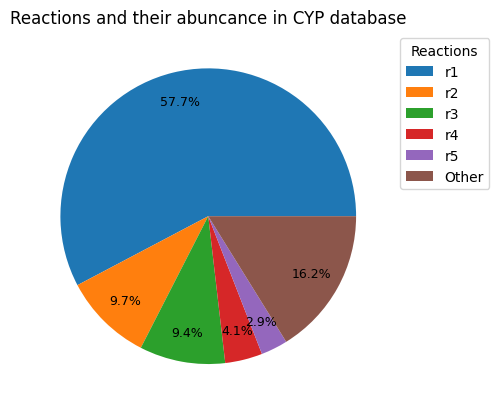

In [31]:
import matplotlib.pyplot as plt
labels = 'r1', 'r2' ,'r3', 'r4', 'r5','Other'
sizes = []
for i, row in reactions_df.iterrows():
    sizes.append(row['Count'])
total_recorded_reactions = sum(sizes)
print(total_recorded_reactions)
sizes_percentage = [x/32.12 for x in sizes[:5]]
other = 100-sum(sizes_percentage)
print(other)
sizes_percentage.append(other)
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes_percentage, autopct='%1.1f%%', textprops={'fontsize': 9}, pctdistance=0.8)
ax.legend(wedges, labels, title="Reactions", loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Reactions and their abuncance in CYP database")
plt.show()

[86, 64, 55, 48, 42, 26, 26, 14, 13]
[16.570327552986527, 12.331406551059741, 10.597302504816966, 9.248554913294807, 8.092485549132956, 5.009633911368019, 5.009633911368019, 2.6974951830443183, 30.44315992292863]
30.44315992292863


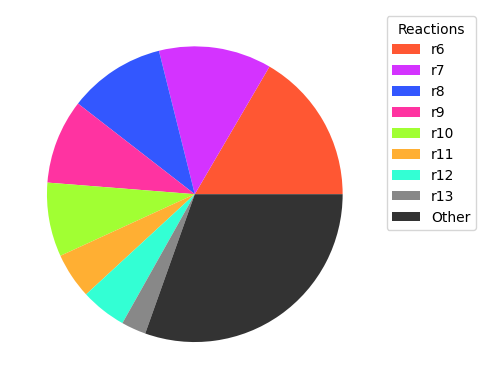

In [32]:
labels2 = 'r6','r7','r8','r9','r10','r11','r12', 'r13', 'Other'
print(sizes[5:14])
sizes_percentage2 = [(x/32.12)/(other/100) for x in sizes[5:13]]
other2 = 100-sum(sizes_percentage2)
sizes_percentage2.append(other2)
print(sizes_percentage2)
print(other2)
fig, ax = plt.subplots()
colors = ['#FF5733', '#D433FF', '#3357FF', '#FF33A1', '#A1FF33', '#FFAF33', '#33FFD4', '#888888', '#333333']
wedges, autotexts = ax.pie(sizes_percentage2, colors = colors, textprops={'fontsize': 8}, pctdistance=0.8)
ax.legend(wedges, labels2, title="Reactions", loc='upper left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()